In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
import matplotlib.colors as colors
from scripts.conversion import *
import pandas as pd
from sklearn.metrics import average_precision_score, precision_recall_curve
import energyflow as ef


In [2]:
distortions = ['shifted', 'smeared', 'tailcut',\
               'eta_smeared','pt_shifted','pt_smeared','all_smeared',\
               'truth'
               ]

In [4]:
cd ..

/home/rd804/discriminator-metric


In [5]:
smeared = np.load('data/smeared.npy')
shifted = np.load('data/shifted.npy')
tailcut = np.load('data/tailcut.npy') + 10**(-8)


truth_weights = np.ones(smeared.shape[0]) / smeared.shape[0]

smeared_weights = truth_weights/smeared
shifted_weights = truth_weights/shifted
tailcut_weights = truth_weights/tailcut

In [5]:
pwd

'/home/rd804/discriminator-metric'

In [13]:
np.unique(smeared_weights)

array([0.02586157, 0.02597702, 0.02770882, 0.17603253, 0.26148521,
       0.44873135, 0.45589914, 0.68977285, 0.85901934, 0.90613758,
       0.97736579, 1.01235565, 1.03605535, 1.03907103, 1.05191626,
       1.05743097, 1.05757125, 1.06106169, 1.06182157, 1.06414949,
       1.06678491, 1.07693598, 1.09615176, 1.09983582, 1.10276755])

In [6]:
distortions = ['shifted','tailcut']

In [32]:
# load data for distorted distributions

s = 'valid'
# load data for distorted distributions
data_dict = {}
for test in distortions:
    if test == 'tailcut':
        exp_name = f'trial_2_pn_lite_{test}'
    else:
        exp_name = f'trial_1_pn_lite_{test}'

    save_dir = f'output/{exp_name}'
    
    if test == 'truth':
        score = np.load(f'{save_dir}/score_15.npy')[:,0]
    else:
        score = np.load(f'{save_dir}/best_model_val_loss.npy')[:,0]

    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__{test}_{s}')['labels'].values
    jets = pd.read_hdf('data/jetnet30_data.h5', f'particle_data_{test}_{s}').values.reshape(-1,30,4)

    mass = mjj_jets(jets)

    data_dict[test] = {'score': score, 'label': label, 'mass': mass, 'jets': jets}




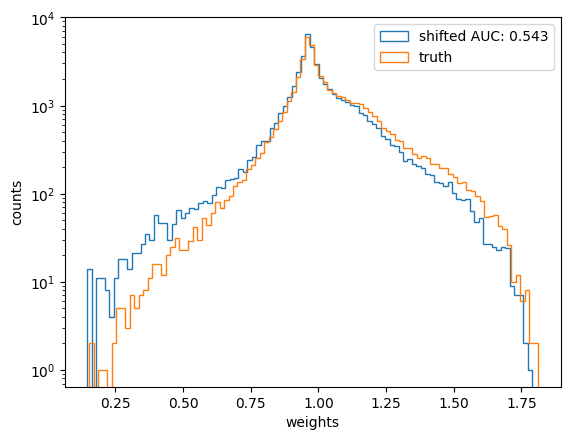

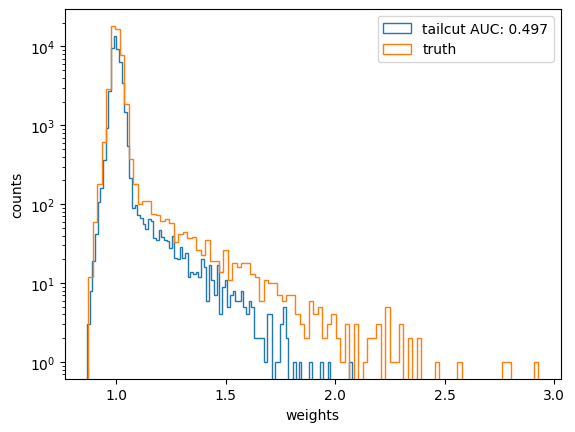

In [33]:
for key, data in data_dict.items():
    auc = roc_auc_score(data['label'], data['score'])
    _weight = data['score']/(1-data['score'])
    label = data['label'][(_weight != np.inf) & (_weight != 0)]
    _weight = _weight[(_weight != np.inf) & (_weight != 0)]

    if key in distortions:
        weight = _weight

        plt.hist(weight[label==0],bins = 100, label = f'{key} AUC: {auc:.3f}',histtype='step',density=False)
        plt.hist(weight[label==1],bins = 100, label = 'truth', histtype='step',density=False)
        plt.legend(loc = 'best')
        plt.xlabel('weights')
        plt.ylabel('counts')
        plt.yscale('log')
        plt.show()

    else:
        weight = np.log(_weight + 10**(-80))


        plt.hist(weight[label==0],bins = 100, label = f'{key} AUC: {auc:.3f}',histtype='step',density=False)
        plt.hist(weight[label==1],bins = 100, label = 'truth', histtype='step',density=False)
        plt.legend(loc = 'upper left')
        plt.xlabel('log(weights)')
        plt.ylabel('counts')
        plt.yscale('log')
        plt.show()

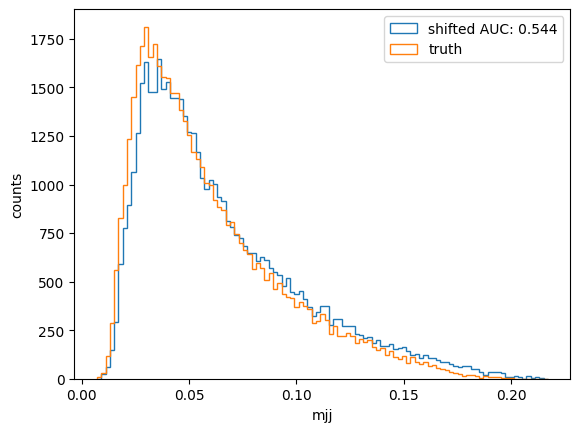

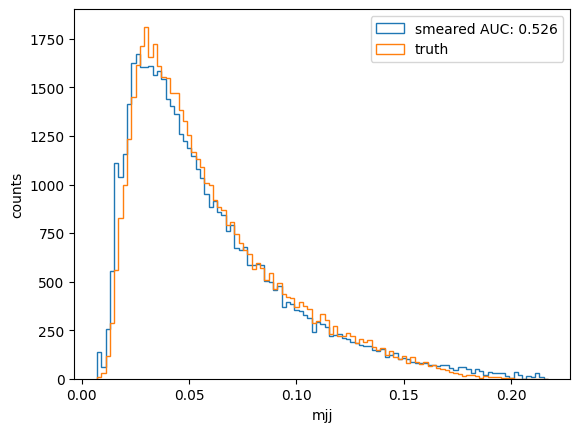

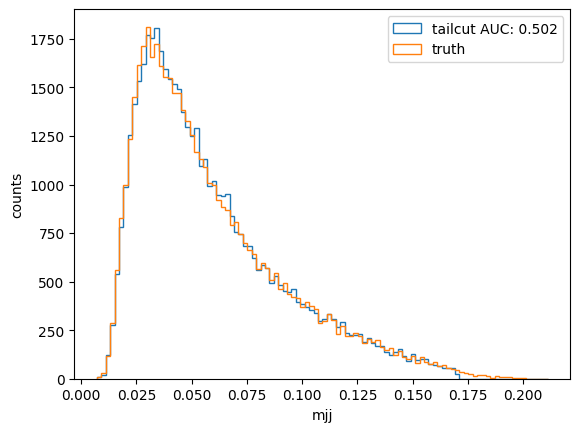

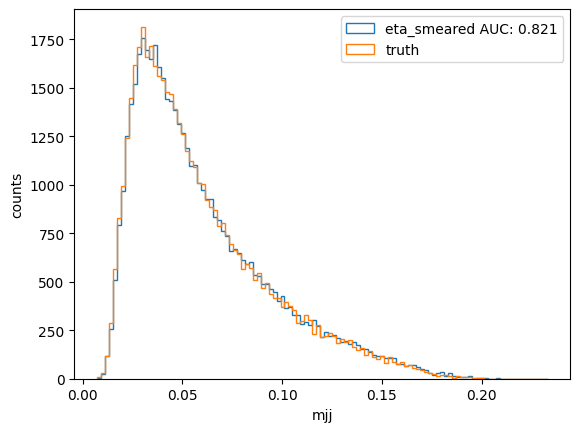

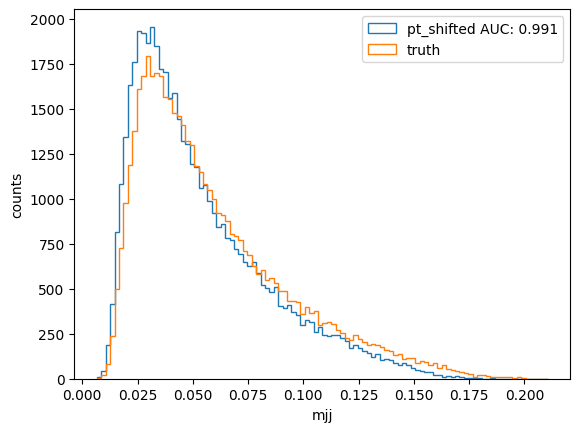

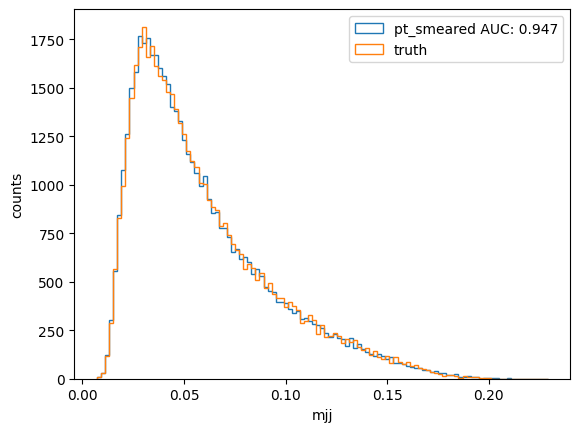

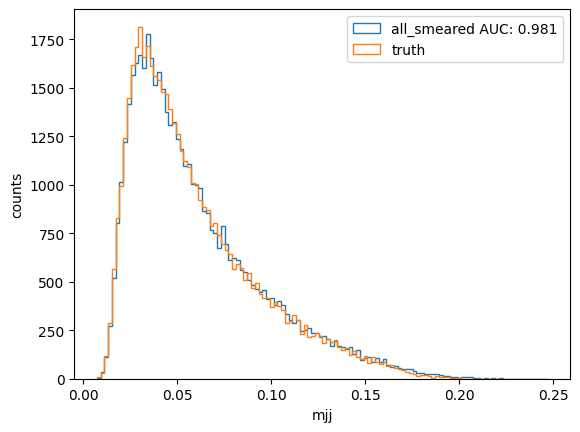

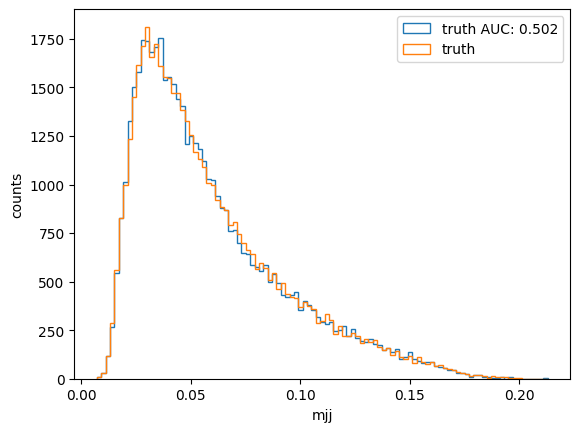

In [7]:
for key, data in data_dict.items():
    auc = roc_auc_score(data['label'], data['score'])
    bins = np.arange(min(data['mass']), max(data['mass']), 0.002)
    plt.hist(data['mass'][data['label']==0],bins = bins, label = f'{key} AUC: {auc:.3f}',histtype='step')
    plt.hist(data['mass'][data['label']==1],bins = bins, label = 'truth', histtype='step')
    plt.legend()
    plt.xlabel('mjj')
    plt.ylabel('counts')
    #plt.yscale('log')
    plt.show()



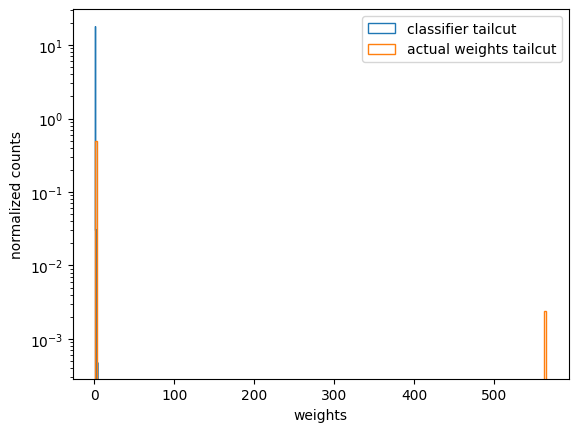

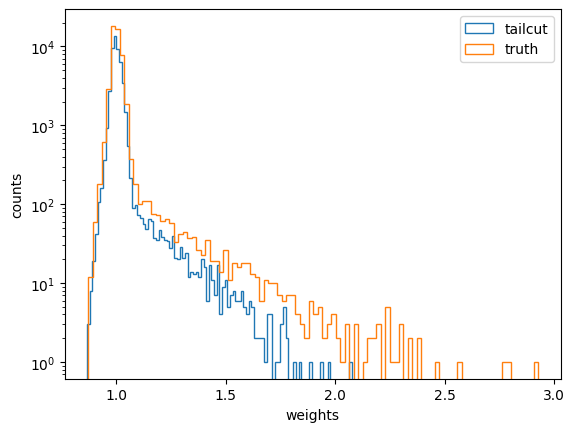

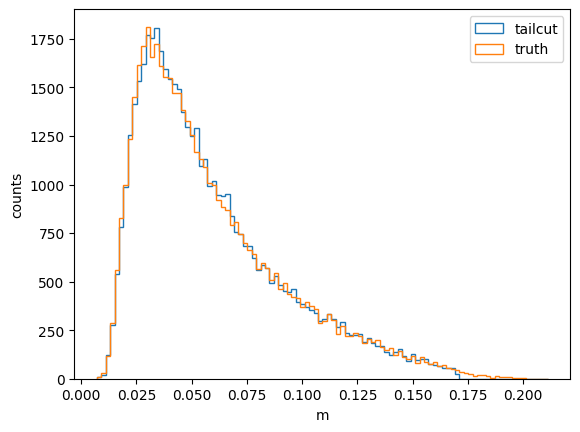

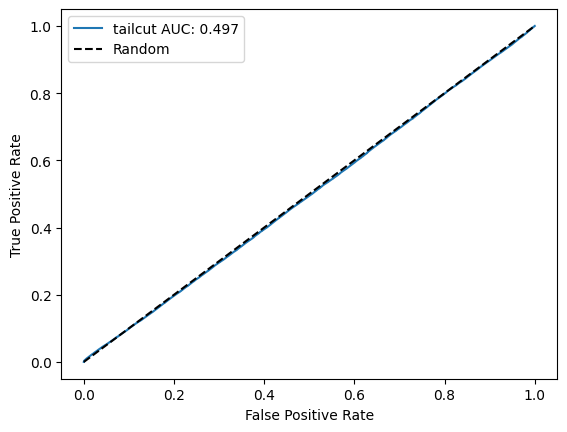

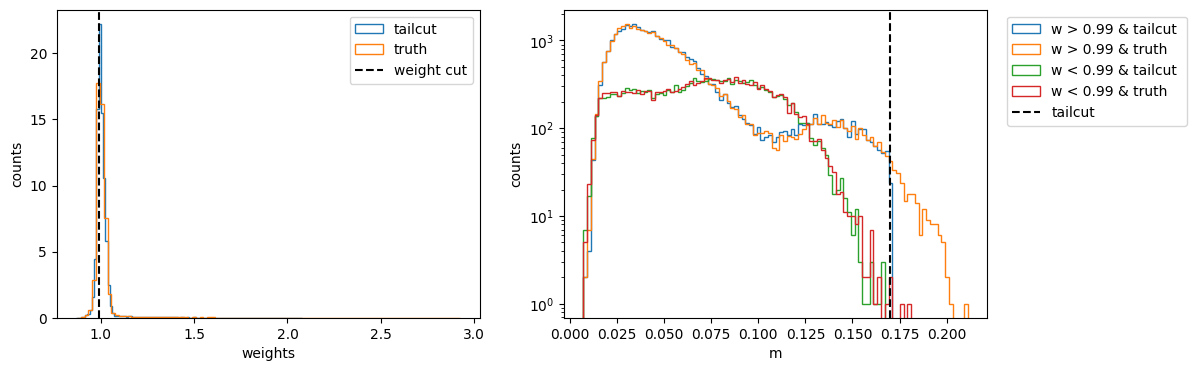

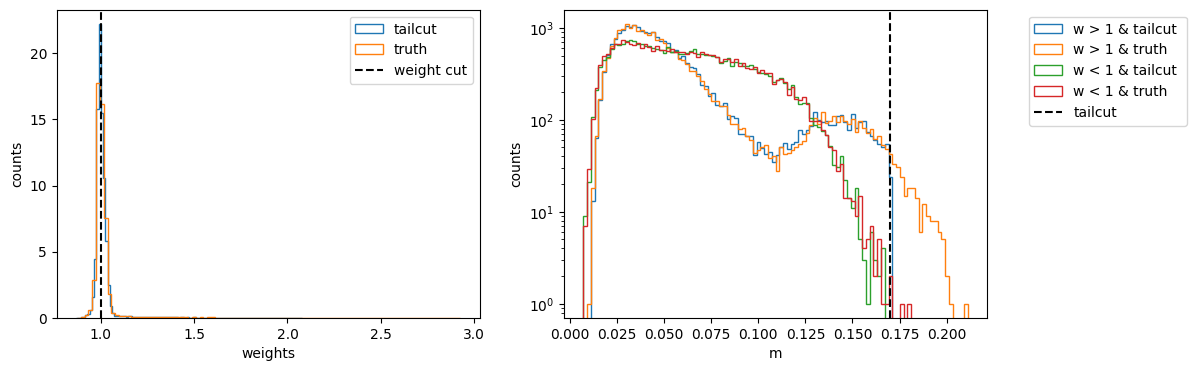

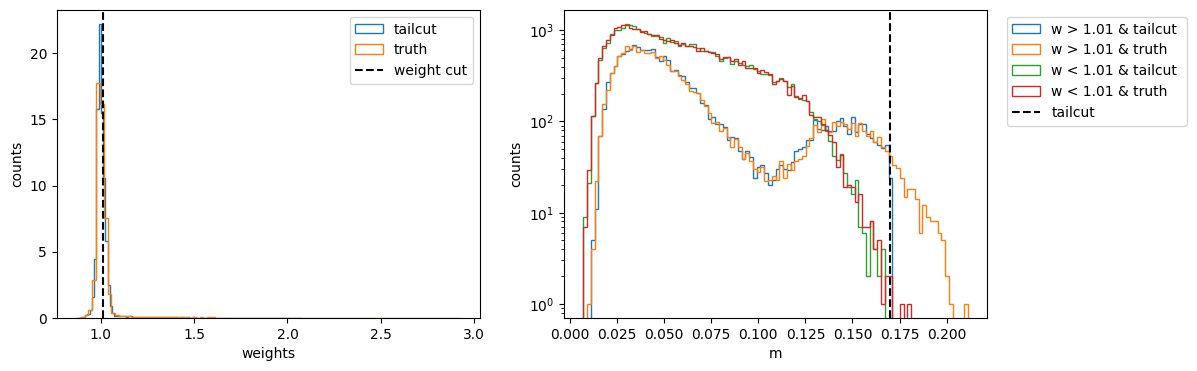

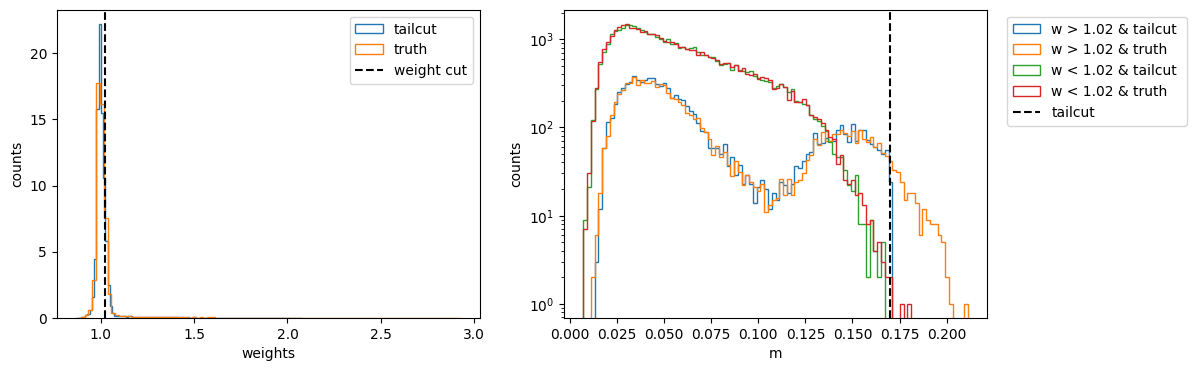

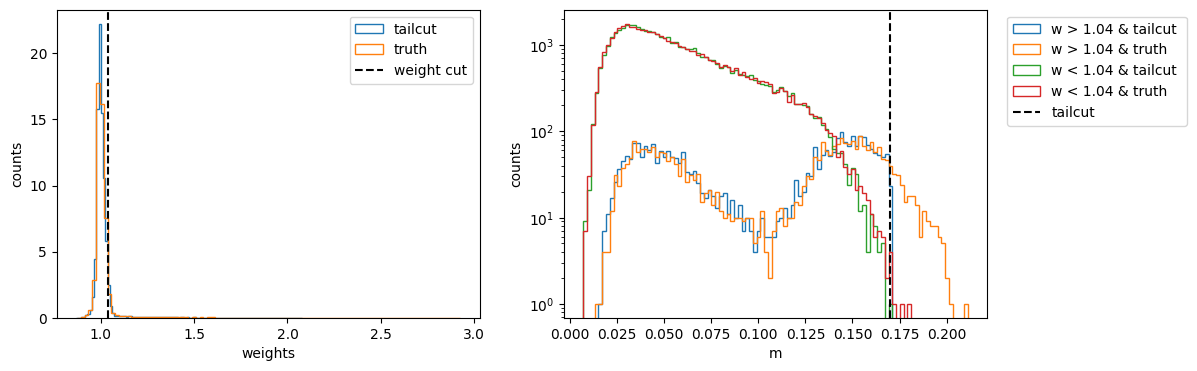

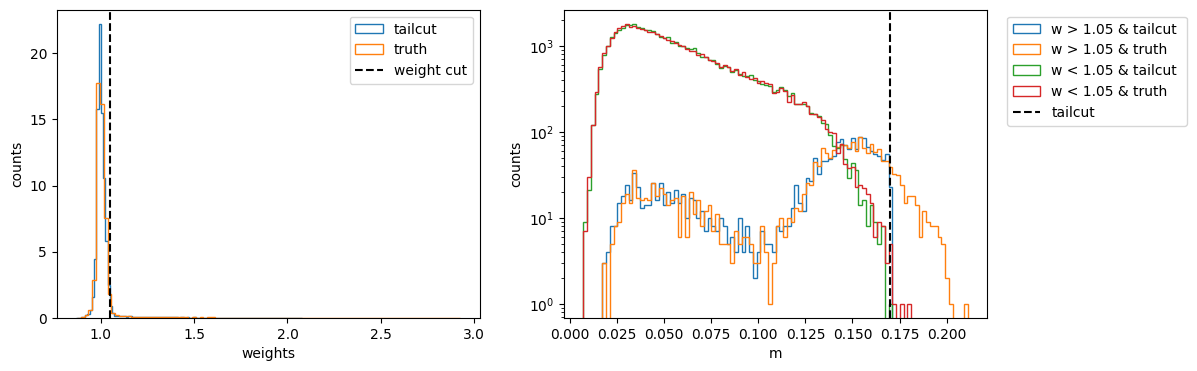

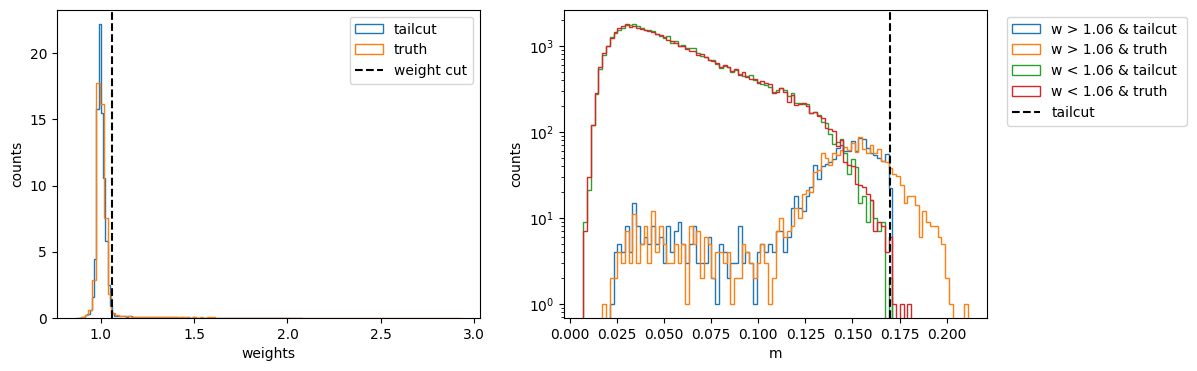

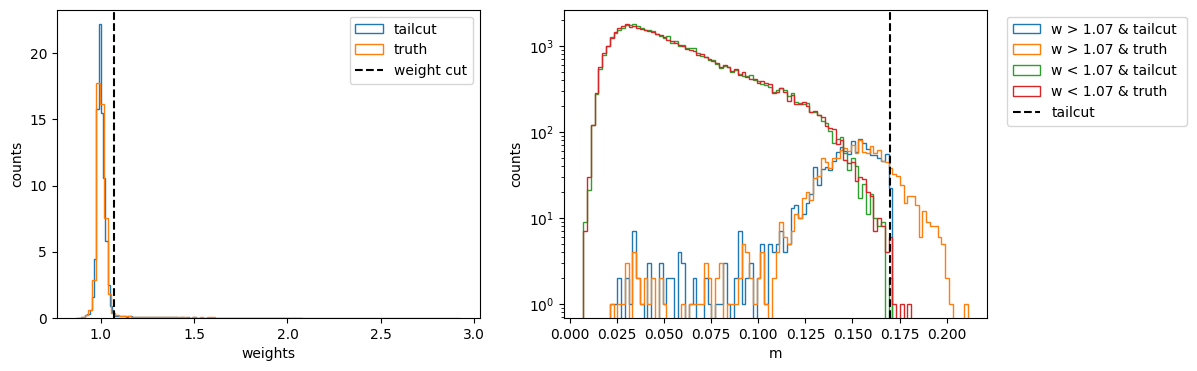

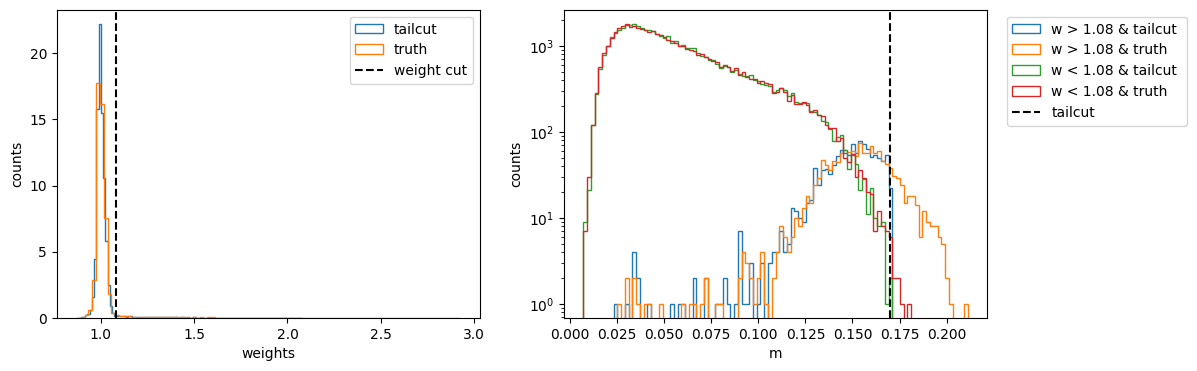

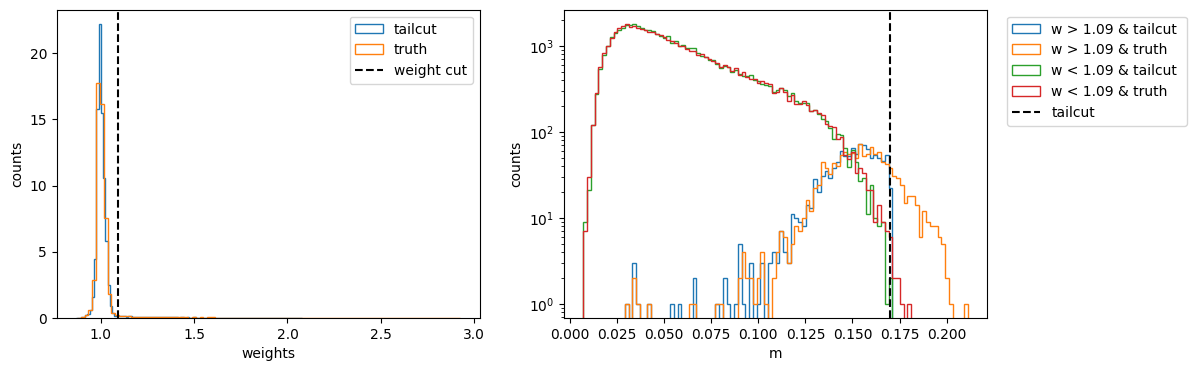

In [34]:
key = 'tailcut'
data = data_dict['tailcut']

weight = data['score']/(1-data['score'])

# compare weight distribution
plt.hist(weight,bins = 100, label = f'classifier {key}',histtype='step',density=True)
plt.hist(tailcut_weights, bins=np.arange(min(tailcut_weights), 
                                        max(tailcut_weights) + 2, 2), 
                                        histtype="step", label=f"actual weights {key}",
                                        density=True)
#plt.hist(weight[data['label']==1],bins = 100, label = 'truth', histtype='step')
plt.legend(loc = 'upper right')
plt.yscale('log')
plt.xlabel('weights')
plt.ylabel('normalized counts')
plt.show() 


# plot weight distribution
plt.hist(weight[data['label']==0],bins = 100, label = f'{key}',histtype='step')
plt.hist(weight[data['label']==1],bins = 100, label = 'truth', histtype='step')
plt.legend(loc = 'upper right')
plt.yscale('log')
plt.xlabel('weights')
plt.ylabel('counts')
plt.show()

# plot mjj distribution
bins = np.arange(min(data['mass']), max(data['mass']), 0.002)
plt.hist(data['mass'][data['label']==0],bins = bins, label = f'{key}',histtype='step')
plt.hist(data['mass'][data['label']==1],bins = bins, label = 'truth', histtype='step')
plt.legend()
plt.xlabel('m')
plt.ylabel('counts')
plt.show()

auc = roc_auc_score(data['label'], data['score'])

# plot roc curve
fpr, tpr, thresholds = roc_curve(data['label'], data['score'])
plt.plot(fpr, tpr, label = f'{key} AUC: {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random',color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


for cut in [0.99,1,1.01,1.02,1.04,1.05, 1.06,1.07,1.08,1.09]:
# plot 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    bins = np.arange(min(data['mass']), max(data['mass']), 0.002)
    ax1.hist(weight[label==0],bins = 100, label = f'{key}',histtype='step',density=True)
    ax1.hist(weight[label==1],bins = 100, label = 'truth', histtype='step',density=True)
    # plot verticle line at 1
    ax1.axvline(x=cut, color='k', linestyle='--', label = 'weight cut')

    ax1.legend(loc = 'upper left')
    ax1.set_xlabel('weights')
    ax1.set_ylabel('counts')
    #ax1.set_yscale('log')
    ax1.legend(loc = 'upper right')

    ax2.hist(data['mass'][(weight>cut) & (data['label']==0)],bins = bins, label = f'w > {cut} & {key} ',histtype='step'
             ,density=False)
    ax2.hist(data['mass'][(weight>cut) & (data['label']==1)],bins = bins, label = f'w > {cut} & truth ', histtype='step',
             density=False)
    ax2.hist(data['mass'][(weight<cut) & (data['label']==0)],bins = bins, label = f'w < {cut} & {key} ',histtype='step'
             ,density=False)
    ax2.hist(data['mass'][(weight<cut) & (data['label']==1)],bins = bins, label = f'w < {cut} & truth ', histtype='step',
             density=False)
    ax2.axvline(x=0.17, color='k', linestyle='--', label = 'tailcut')
    ax2.legend(bbox_to_anchor=(1.49,1),loc = 'upper right')

    plt.xlabel('m')
    plt.ylabel('counts')
    plt.yscale('log')
    plt.show()


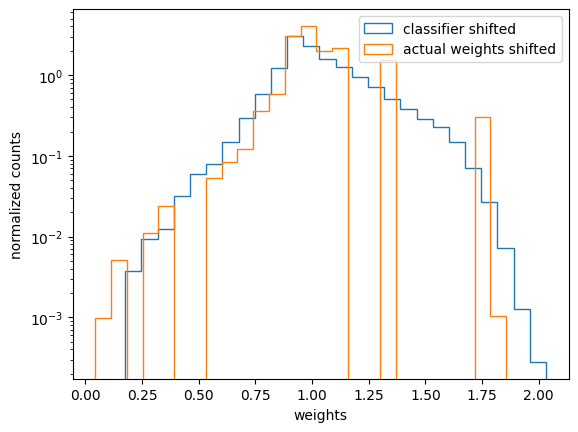

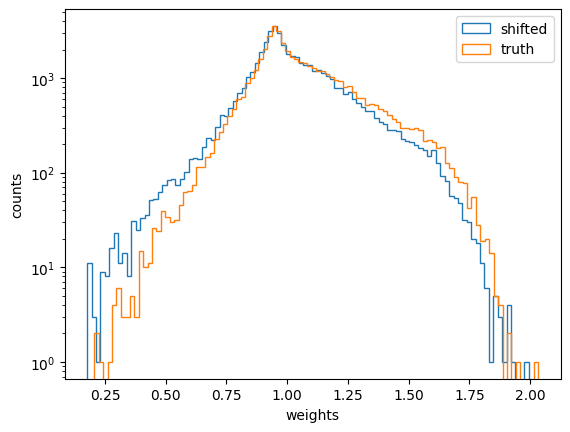

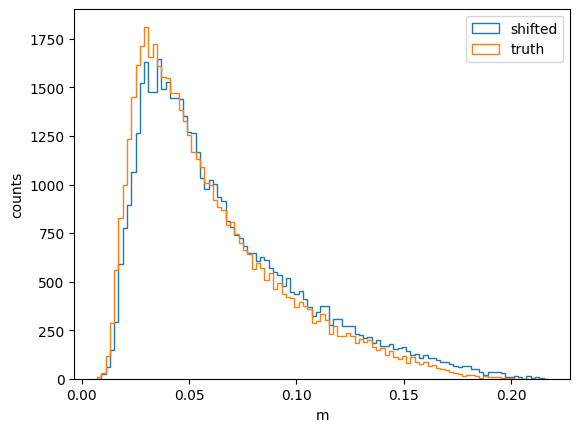

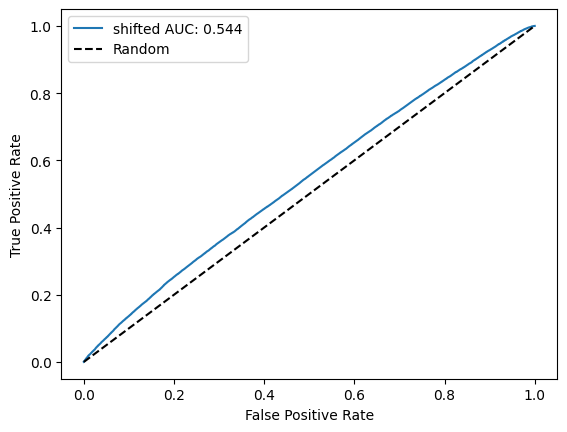

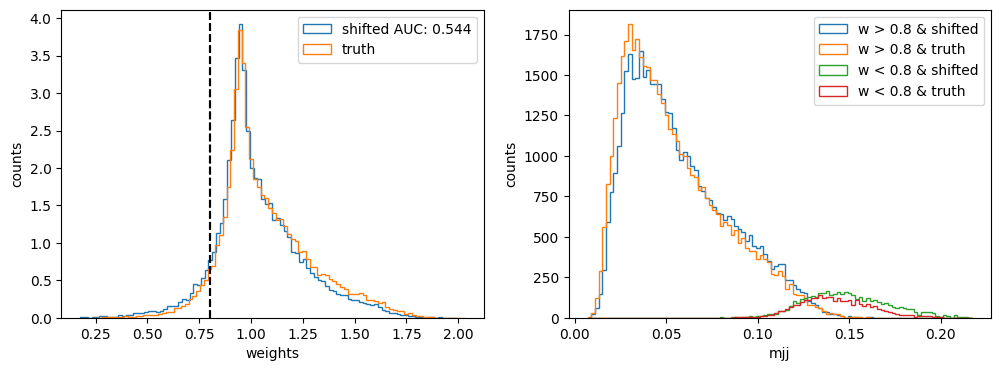

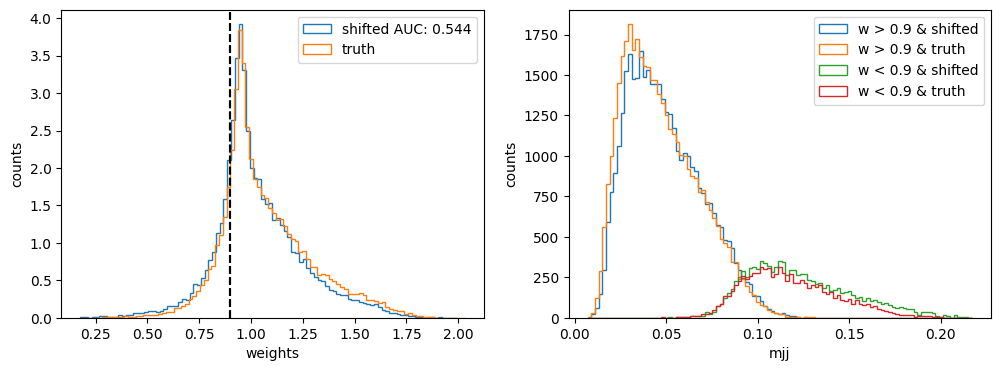

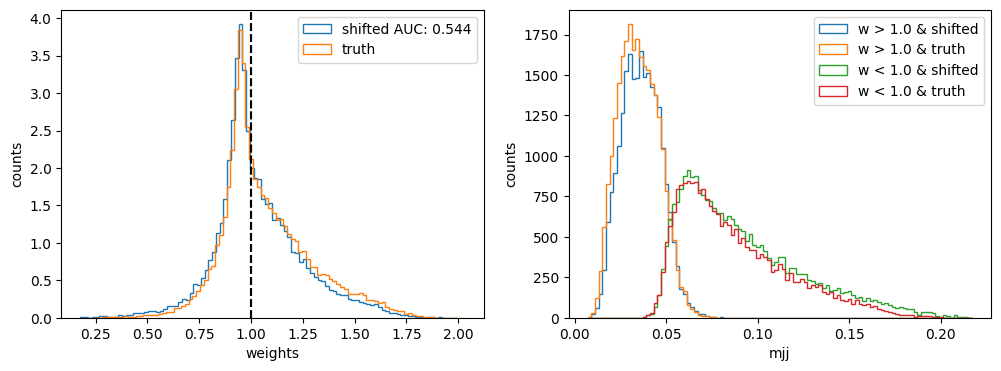

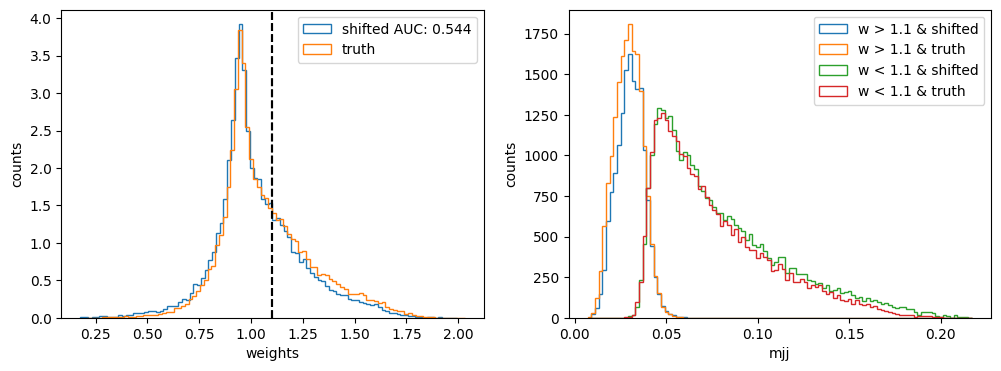

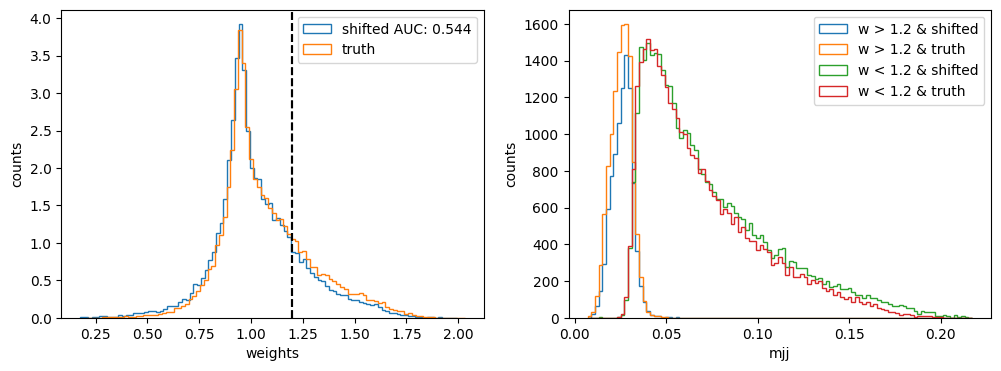

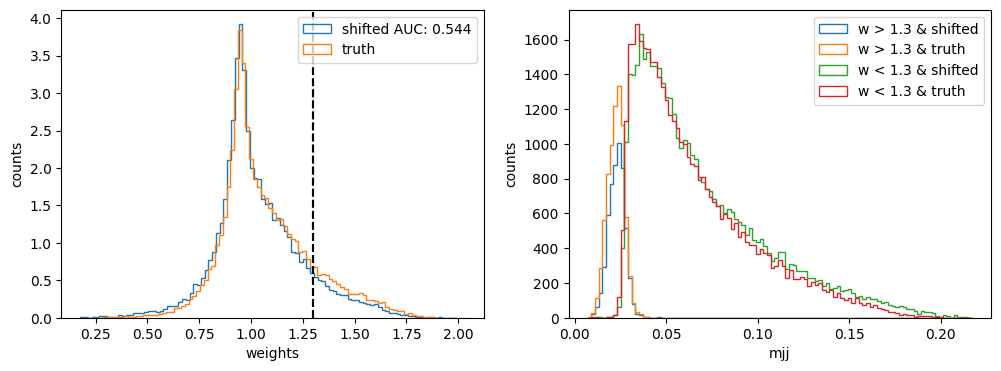

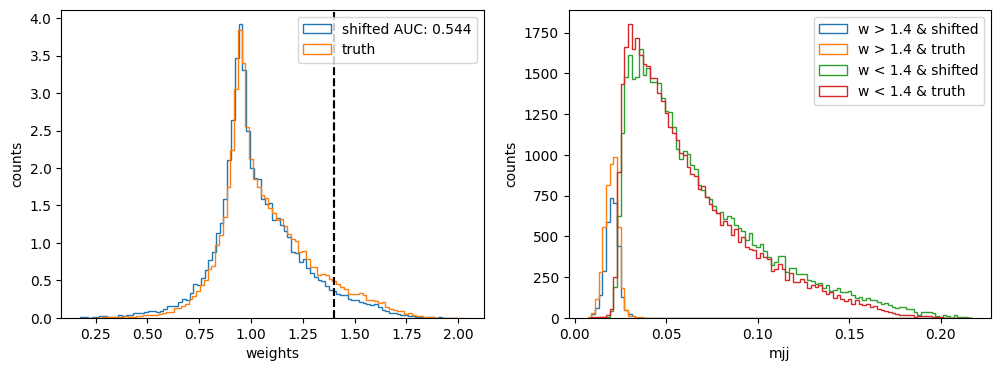

In [27]:
key = 'shifted'
data = data_dict['shifted']
auc = roc_auc_score(data['label'], data['score'])

weight = data['score']/(1-data['score'])

# compare weight distribution
plt.hist(weight,bins = 26, label = f'classifier {key}',histtype='step',density=True)
plt.hist(shifted_weights, bins=26, label=f"actual weights {key}",density=True,histtype='step')
#plt.hist(weight[data['label']==1],bins = 100, label = 'truth', histtype='step')
plt.legend(loc = 'upper right')
plt.yscale('log')
plt.xlabel('weights')
plt.ylabel('normalized counts')
plt.show() 

# plot weight distribution
plt.hist(weight[data['label']==0],bins = 100, label = f'{key}',histtype='step')
plt.hist(weight[data['label']==1],bins = 100, label = 'truth', histtype='step')
plt.legend(loc = 'upper right')
plt.yscale('log')
plt.xlabel('weights')
plt.ylabel('counts')
plt.show()

# plot mjj distribution
bins = np.arange(min(data['mass']), max(data['mass']), 0.002)
plt.hist(data['mass'][data['label']==0],bins = bins, label = f'{key}',histtype='step')
plt.hist(data['mass'][data['label']==1],bins = bins, label = 'truth', histtype='step')
plt.legend()
plt.xlabel('m')
plt.ylabel('counts')
plt.show()

auc = roc_auc_score(data['label'], data['score'])

# plot roc curve
fpr, tpr, thresholds = roc_curve(data['label'], data['score'])
plt.plot(fpr, tpr, label = f'{key} AUC: {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random',color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


#label = data['label'][(_weight != np.inf) & (_weight != 0)]
#_weight = _weight[(_weight != np.inf) & (_weight != 0)]

#weight = np.log(_weight + 10**(-80))

# make 2 plots side by side

cuts = np.arange(0.8, 1.5, 0.1)
# plot 1

for cut in cuts:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    bins = np.arange(min(data['mass']), max(data['mass']), 0.002)
    ax1.hist(weight[label==0],bins = 100, label = f'{key} AUC: {auc:.3f}',histtype='step',density=True)
    ax1.hist(weight[label==1],bins = 100, label = 'truth', histtype='step',density=True)
    # plot verticle line at 1
    ax1.axvline(x=cut, color='k', linestyle='--')
    ax1.axvline(x=cut, color='k', linestyle='--')

    ax1.legend(loc = 'upper left')
    ax1.set_xlabel('weights')
    ax1.set_ylabel('counts')
    #ax1.set_yscale('log')
    ax1.legend(loc = 'upper right')
    
    ax2.hist(data['mass'][(weight>cut) & (data['label']==0)],bins = bins, label = f'w > {cut:.1f} & {key}',histtype='step'
             ,density=False)
    ax2.hist(data['mass'][(weight>cut) & (data['label']==1)],bins = bins, label = f'w > {cut:.1f} & truth', histtype='step',
             density=False)
    ax2.hist(data['mass'][(weight<cut) & (data['label']==0)],bins = bins, label = f'w < {cut:.1f} & {key}',histtype='step'
             ,density=False)
    ax2.hist(data['mass'][(weight<cut) & (data['label']==1)],bins = bins, label = f'w < {cut:.1f} & truth', histtype='step',
             density=False)
     #ax2.axvline(x=0.17, color='k', linestyle='--', label = 'tailcut')

    plt.legend()
    plt.xlabel('mjj')
    plt.ylabel('counts')
    #plt.yscale('log')
    plt.show()



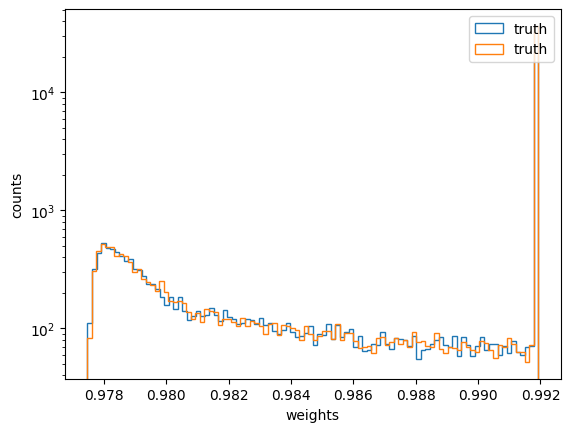

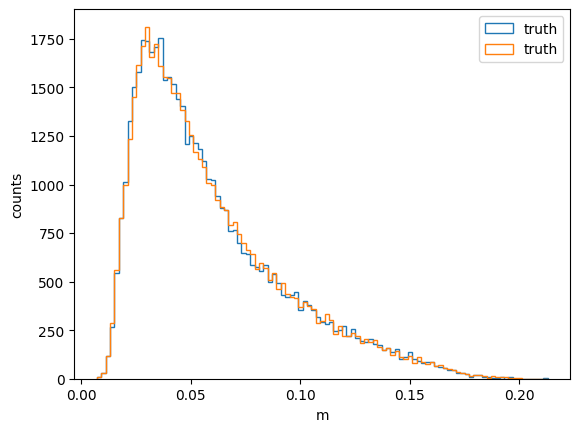

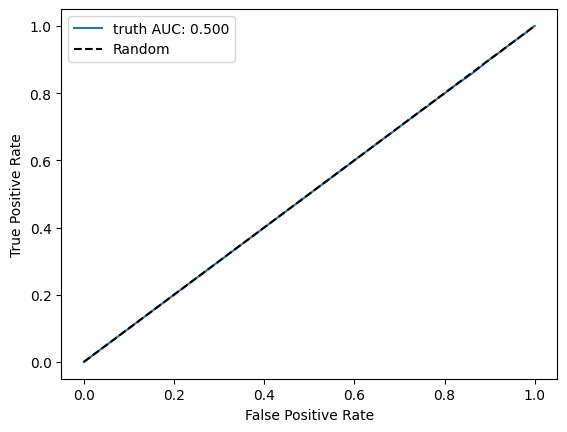

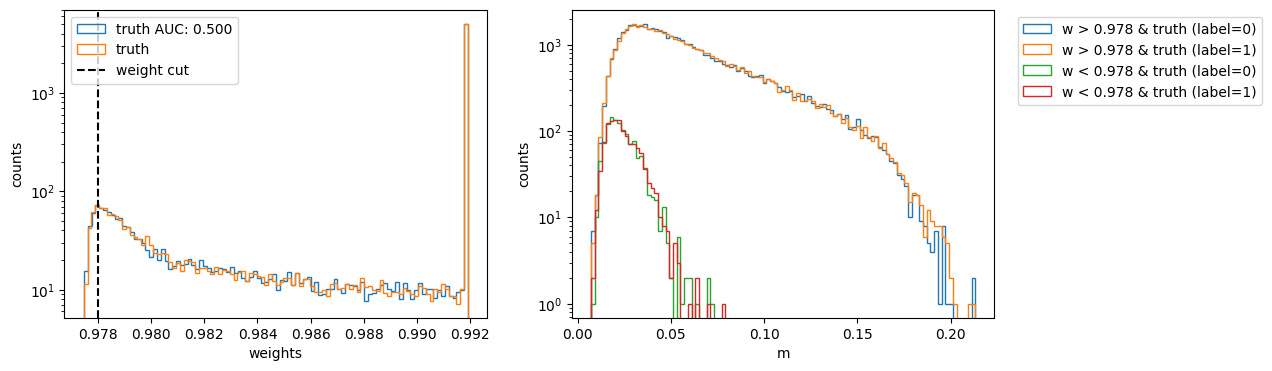

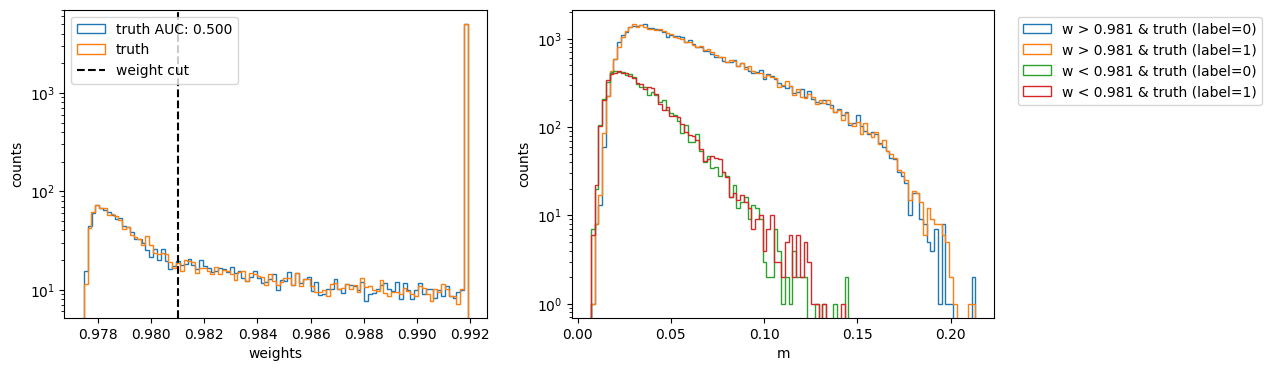

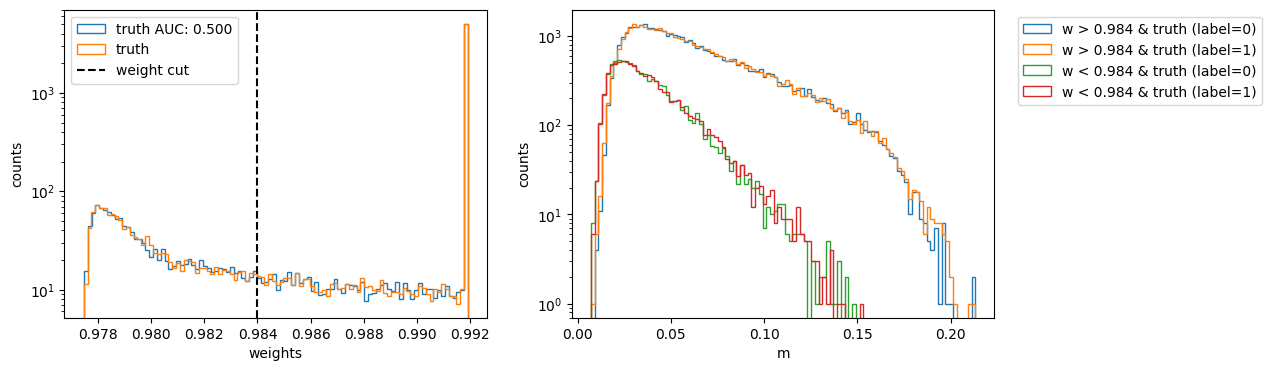

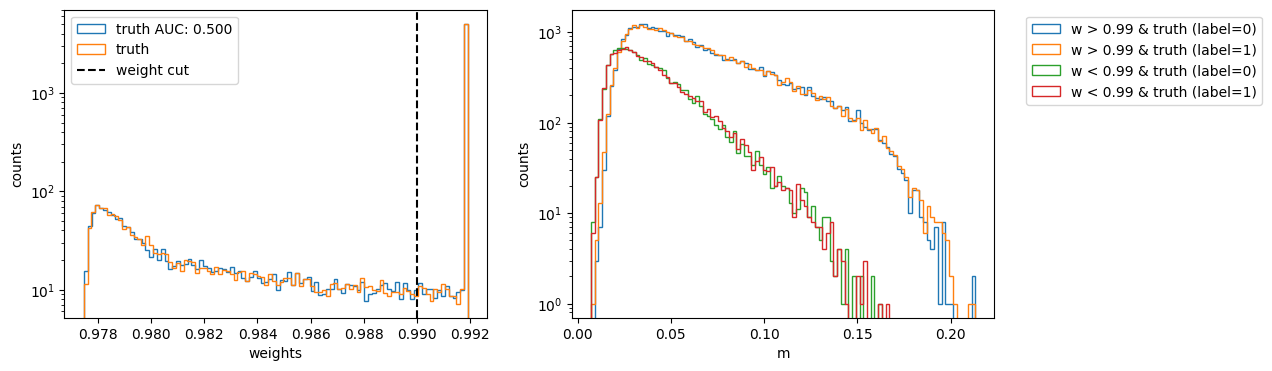

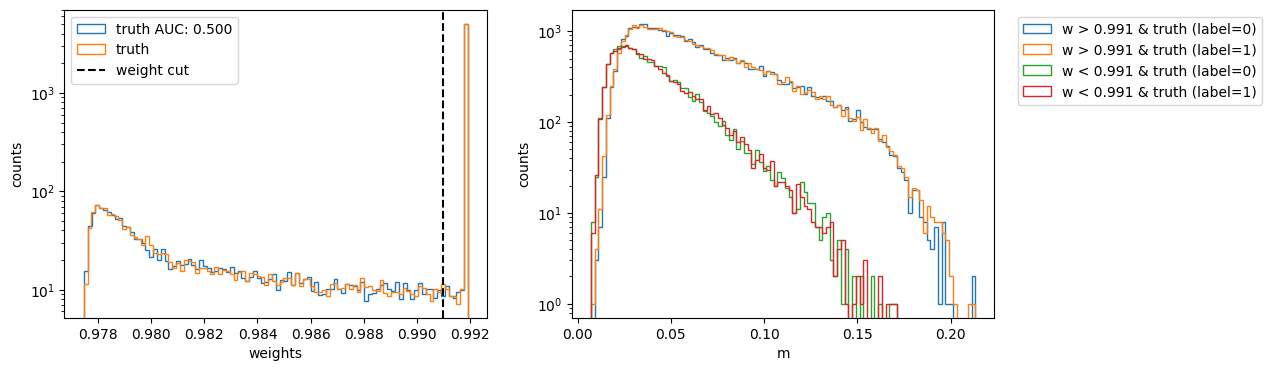

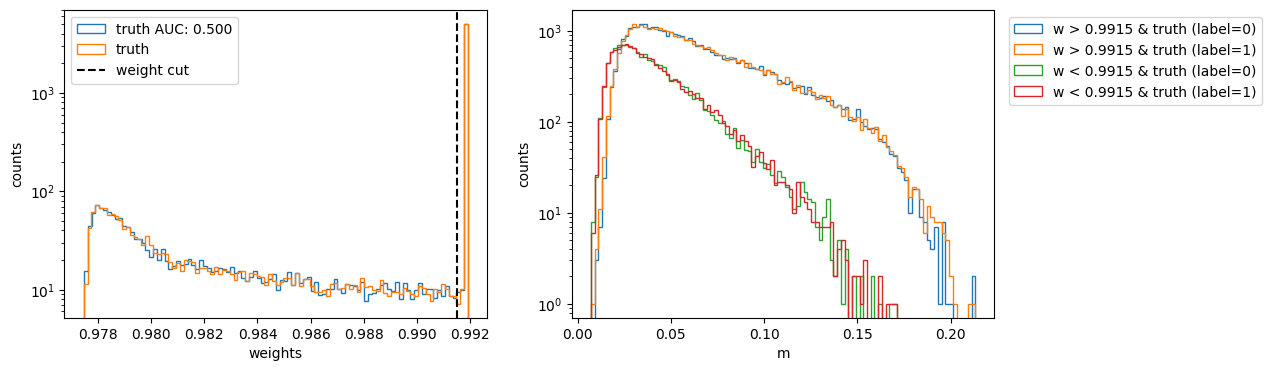

In [43]:
key = 'truth'
data = data_dict[key]

weight = data['score']/(1-data['score'])
#label = data['label'][(_weight != np.inf) & (_weight != 0)]
#_weight = _weight[(_weight != np.inf) & (_weight != 0)]



# plot weight distribution
plt.hist(weight[data['label']==0],bins = 100, label = f'{key}',histtype='step')
plt.hist(weight[data['label']==1],bins = 100, label = 'truth', histtype='step')
plt.legend(loc = 'upper right')
plt.yscale('log')
plt.xlabel('weights')
plt.ylabel('counts')
plt.show()

# plot mjj distribution
bins = np.arange(min(data['mass']), max(data['mass']), 0.002)
plt.hist(data['mass'][data['label']==0],bins = bins, label = f'{key}',histtype='step')
plt.hist(data['mass'][data['label']==1],bins = bins, label = 'truth', histtype='step')
plt.legend()
plt.xlabel('m')
plt.ylabel('counts')
plt.show()

auc = roc_auc_score(data['label'], data['score'])

# plot roc curve
fpr, tpr, thresholds = roc_curve(data['label'], data['score'])
plt.plot(fpr, tpr, label = f'{key} AUC: {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random',color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()





auc = roc_auc_score(data['label'], data['score'])
#weight = np.log(_weight + 10**(-80))

# make 2 plots side by side

for cut in [0.978, 0.981, 0.984, 0.99, 0.991, 0.9915]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# plot 1
    bins = np.arange(min(data['mass']), max(data['mass']), 0.002)
    ax1.hist(weight[data['label']==0],bins = 100, label = f'{key} AUC: {auc:.3f}',histtype='step',density=True)
    ax1.hist(weight[data['label']==1],bins = 100, label = 'truth', histtype='step',density=True)
    # plot verticle line at 1
    ax1.axvline(x=cut, color='k', linestyle='--', label = 'weight cut')

    ax1.legend(loc = 'upper left')
    ax1.set_xlabel('weights')
    ax1.set_ylabel('counts')
    ax1.set_yscale('log')
    ax1.legend(loc = 'upper left')

    ax2.hist(data['mass'][(weight>cut) & (data['label']==0)],bins = bins, label = f'w > {cut} & {key} (label=0)',histtype='step'
             ,density=False)
    ax2.hist(data['mass'][(weight>cut) & (data['label']==1)],bins = bins, label = f'w > {cut} & truth (label=1)', histtype='step',
             density=False)
    ax2.hist(data['mass'][(weight<cut) & (data['label']==0)],bins = bins, label = f'w < {cut} & {key} (label=0)',histtype='step'
             ,density=False)
    ax2.hist(data['mass'][(weight<cut) & (data['label']==1)],bins = bins, label = f'w < {cut} & truth (label=1)', histtype='step',
             density=False)
    ax2.legend(bbox_to_anchor=(1.65,1),loc = 'upper right')

    plt.xlabel('m')
    plt.ylabel('counts')
    plt.yscale('log')
    plt.show()



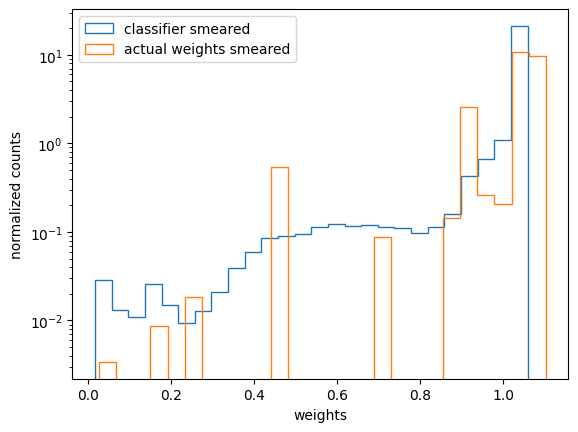

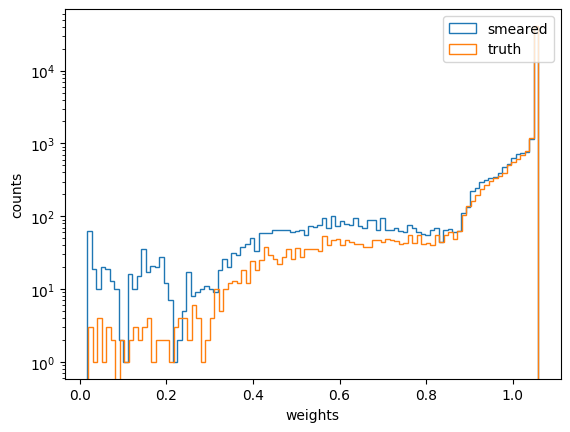

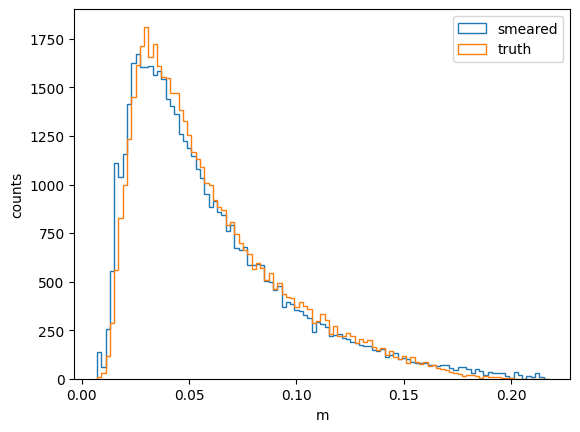

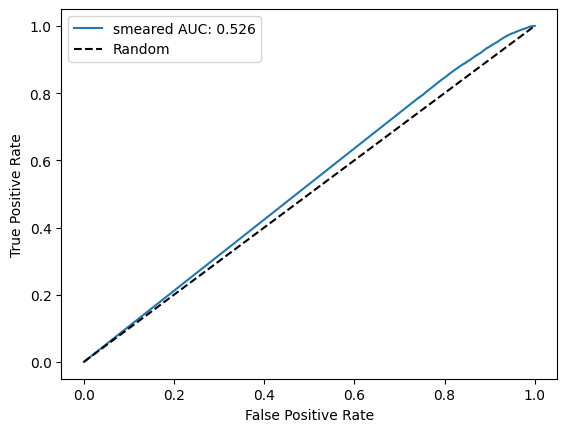

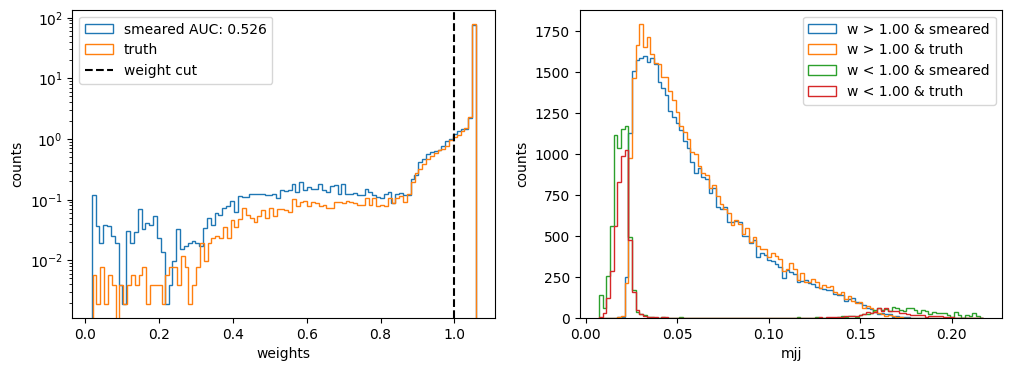

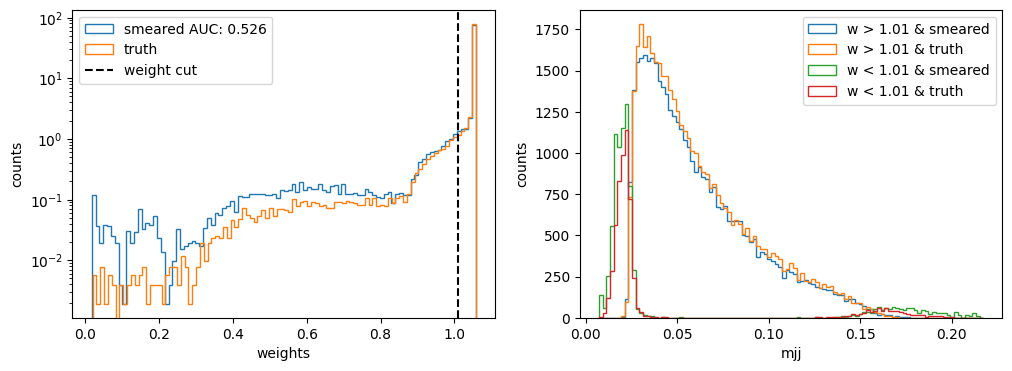

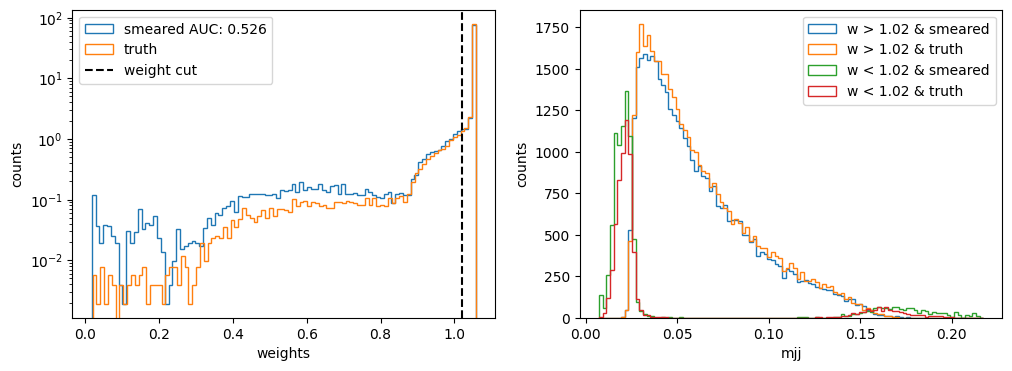

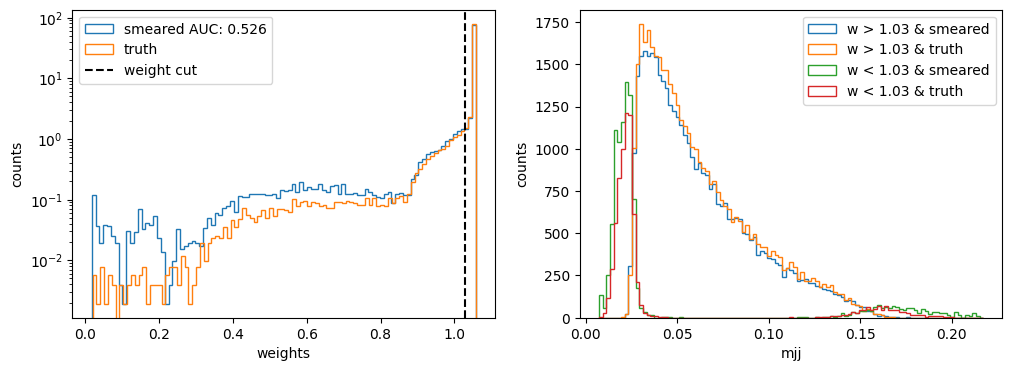

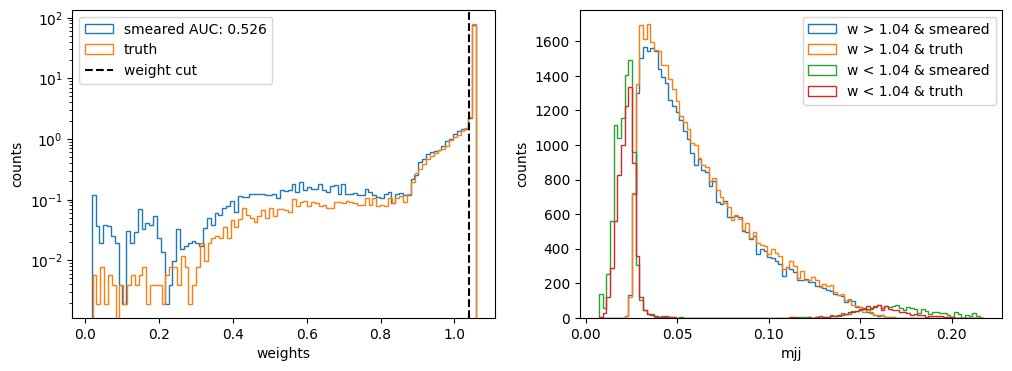

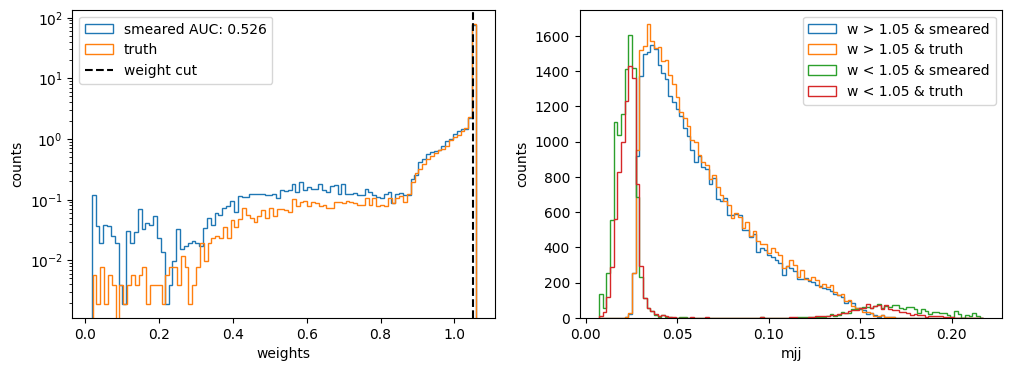

In [18]:

key = 'smeared'
data = data_dict[key]
auc = roc_auc_score(data['label'], data['score'])
weight = data['score']/(1-data['score'])


# compare weight distribution
plt.hist(weight,bins = 26, label = f'classifier {key}',histtype='step',density=True)
plt.hist(smeared_weights, bins=26, label=f"actual weights {key}",density=True,histtype='step')
#plt.hist(weight[data['label']==1],bins = 100, label = 'truth', histtype='step')
plt.legend(loc = 'upper left')
plt.yscale('log')
plt.xlabel('weights')
plt.ylabel('normalized counts')
plt.show() 



# plot weight distribution
plt.hist(weight[data['label']==0],bins = 100, label = f'{key}',histtype='step')
plt.hist(weight[data['label']==1],bins = 100, label = 'truth', histtype='step')
plt.legend(loc = 'upper right')
plt.yscale('log')
plt.xlabel('weights')
plt.ylabel('counts')
plt.show()

# plot mjj distribution
bins = np.arange(min(data['mass']), max(data['mass']), 0.002)
plt.hist(data['mass'][data['label']==0],bins = bins, label = f'{key}',histtype='step')
plt.hist(data['mass'][data['label']==1],bins = bins, label = 'truth', histtype='step')
plt.legend()
plt.xlabel('m')
plt.ylabel('counts')
plt.show()

auc = roc_auc_score(data['label'], data['score'])

# plot roc curve
fpr, tpr, thresholds = roc_curve(data['label'], data['score'])
plt.plot(fpr, tpr, label = f'{key} AUC: {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random',color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()



for cut in [1,1.01,1.02,1.03,1.04,1.05]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# plot 1
    bins = np.arange(min(data['mass']), max(data['mass']), 0.002)
    ax1.hist(weight[label==0],bins = 100, label = f'{key} AUC: {auc:.3f}',histtype='step',density=True)
    ax1.hist(weight[label==1],bins = 100, label = 'truth', histtype='step',density=True)
    # plot verticle line at 1
    ax1.axvline(x=cut, color='k', linestyle='--', label = 'weight cut')

    ax1.legend(loc = 'upper left')
    ax1.set_xlabel('weights')
    ax1.set_ylabel('counts')
    ax1.set_yscale('log')
    ax1.legend(loc = 'upper left')

    ax2.hist(data['mass'][(weight>cut) & (data['label']==0)],bins = bins, label = f'w > {cut:.2f} & {key}',histtype='step'
             ,density=False)
    ax2.hist(data['mass'][(weight>cut) & (data['label']==1)],bins = bins, label = f'w > {cut:.2f} & truth', histtype='step',
             density=False)
    ax2.hist(data['mass'][(weight<cut) & (data['label']==0)],bins = bins, label = f'w < {cut:.2f} & {key}',histtype='step'
             ,density=False)
    ax2.hist(data['mass'][(weight<cut) & (data['label']==1)],bins = bins, label = f'w < {cut:.2f} & truth', histtype='step',
             density=False)
    ax2.legend(loc = 'upper right')

    plt.xlabel('mjj')
    plt.ylabel('counts')
    #plt.yscale('log')
    plt.show()



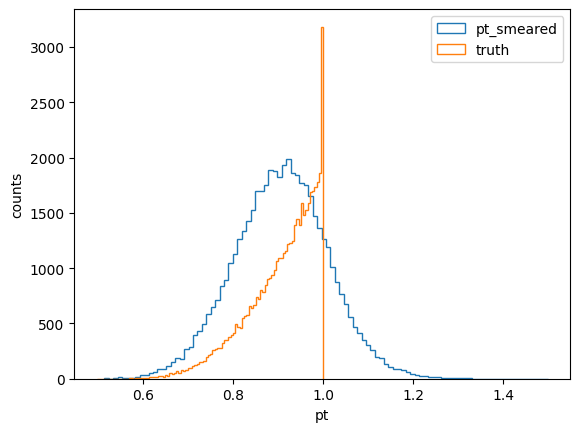

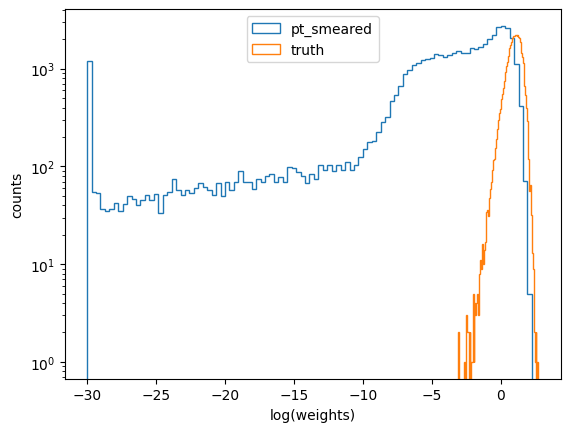

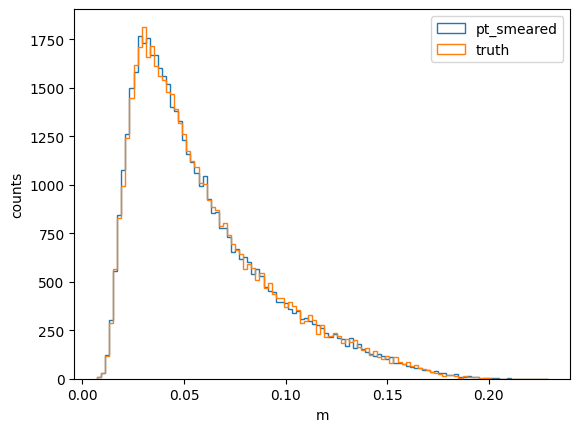

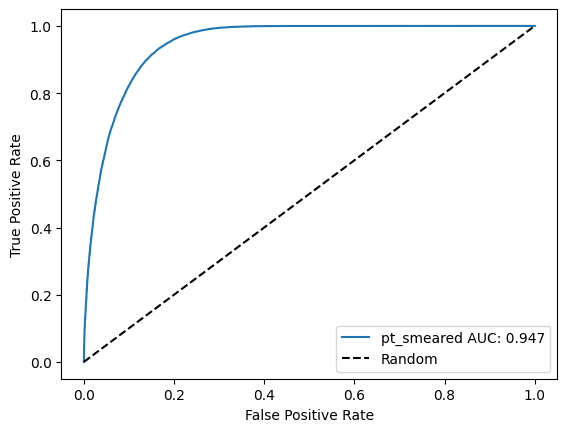

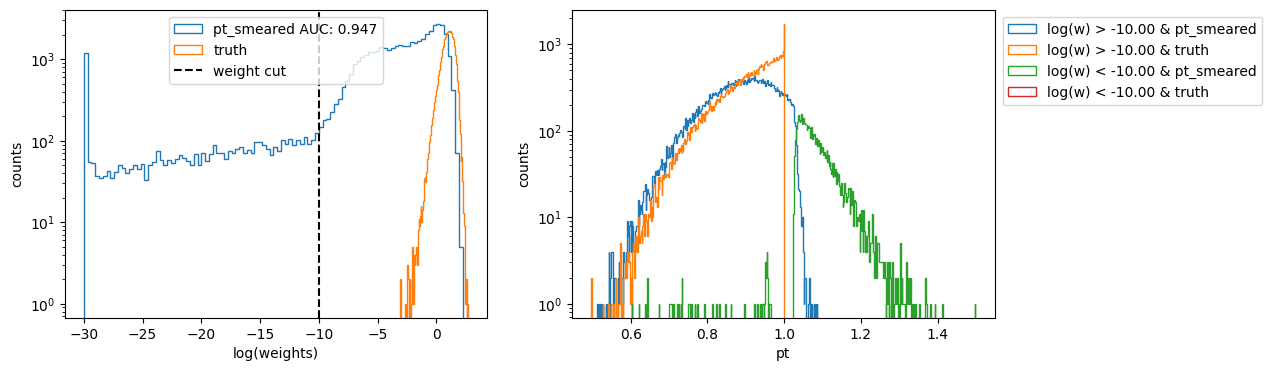

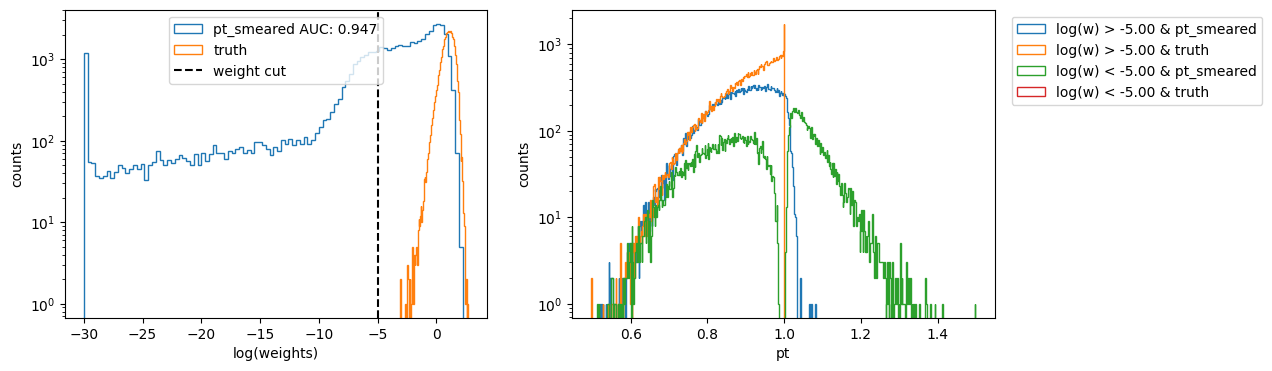

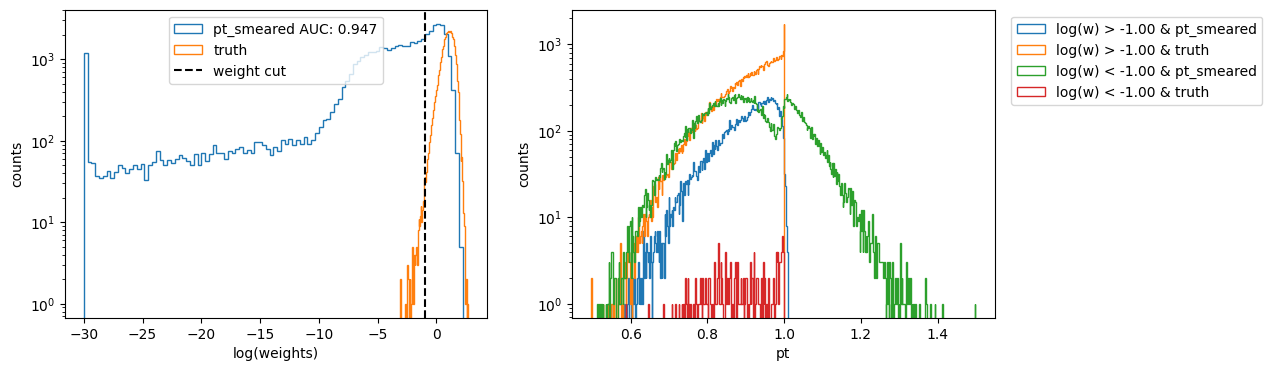

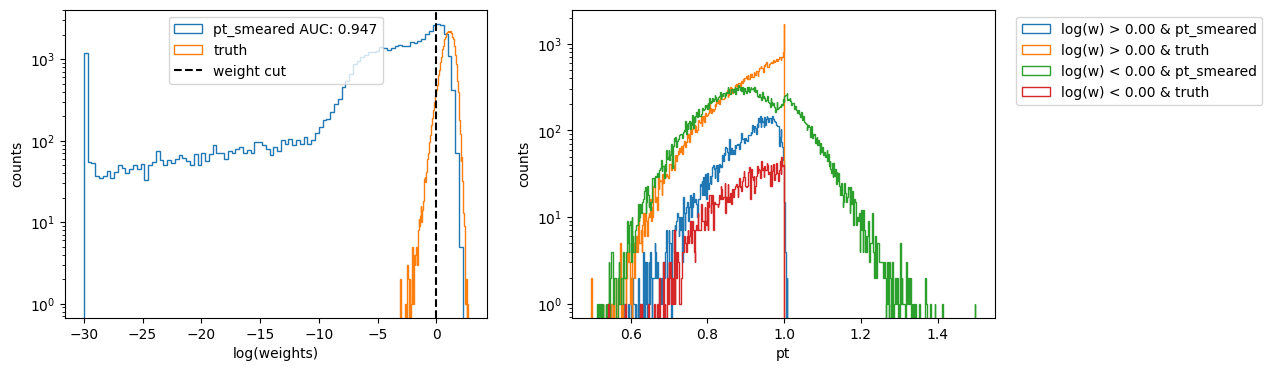

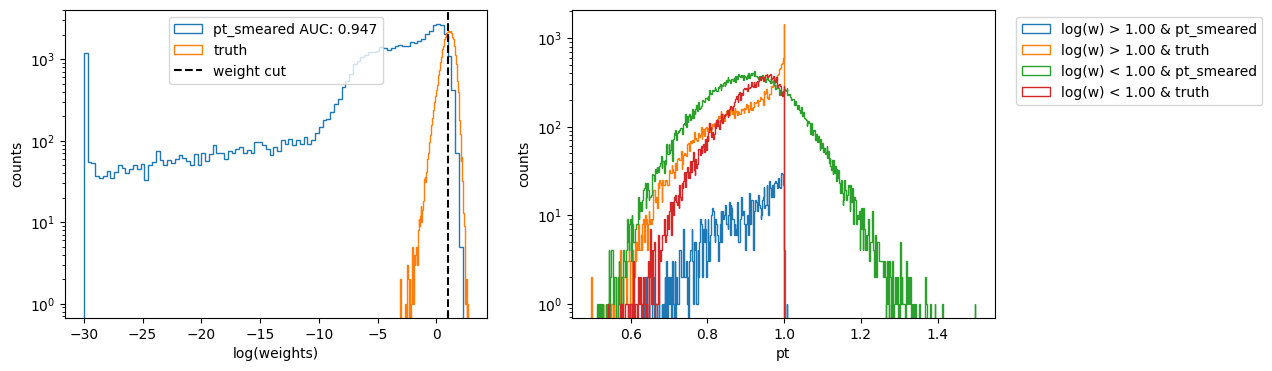

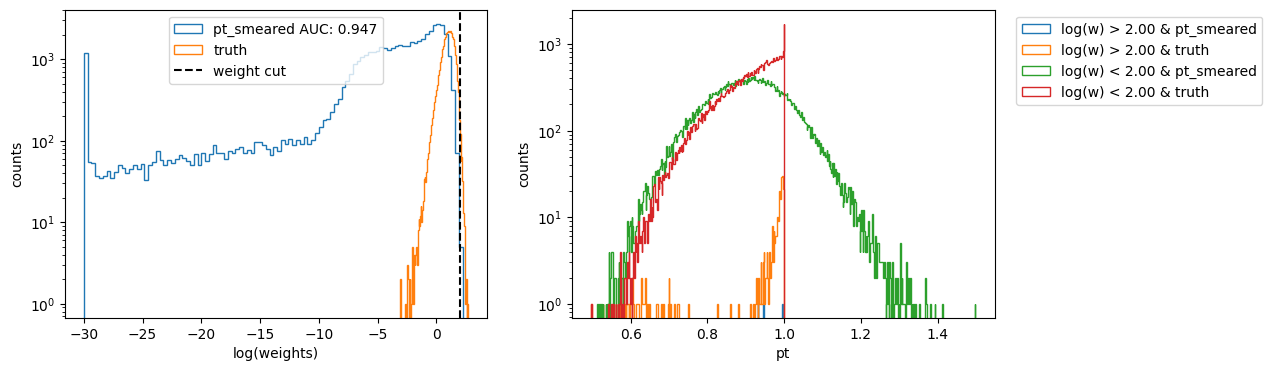

In [12]:
key = 'pt_smeared'
data = data_dict[key]
auc = roc_auc_score(data['label'], data['score'])
weight_ = data['score']/(1-data['score'])

#label = data['label'][(weight_!=np.inf) | (weight_!=0.)]
#weight_ = weight_[(weight_!=np.inf) | (weight_!=0.)]

weight = np.log10(weight_ + 10**(-30))

jets = data['jets']

pt_ = pt_jets(jets)
 
# plot pt distribution
plt.hist(pt_[data['label']==0],bins = 100, label = key,histtype='step')
plt.hist(pt_[data['label']==1],bins = 100, label = 'truth', histtype='step')
plt.legend(loc = 'upper right')
plt.xlabel('pt')
plt.ylabel('counts')
plt.show()

plt.hist(weight[data['label']==0],bins = 100, label = f'{key}',histtype='step')
plt.hist(weight[data['label']==1],bins = 100, label = 'truth', histtype='step')
plt.legend(loc = 'upper center')
plt.yscale('log')
plt.xlabel('log(weights)')
plt.ylabel('counts')
plt.show()

# plot mjj distribution
bins = np.arange(min(data['mass']), max(data['mass']), 0.002)
plt.hist(data['mass'][data['label']==0],bins = bins, label = f'{key}',histtype='step')
plt.hist(data['mass'][data['label']==1],bins = bins, label = 'truth', histtype='step')
plt.legend()
plt.xlabel('m')
plt.ylabel('counts')
plt.show()

auc = roc_auc_score(data['label'], data['score'])

# plot roc curve
fpr, tpr, thresholds = roc_curve(data['label'], data['score'])
plt.plot(fpr, tpr, label = f'{key} AUC: {auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random',color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()



for cut in [-10,-5,-1,0, 1, 2]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# plot 1
    bins = np.arange(min(pt_), max(pt_), 0.002)
    ax1.hist(weight[data['label']==0],bins = 100, label = f'{key} AUC: {auc:.3f}',histtype='step',
             density=False)
    ax1.hist(weight[data['label']==1],bins = 100, label = 'truth', histtype='step',
             density=False)
    # plot verticle line at 1
    ax1.axvline(x=cut, color='k', linestyle='--', label = 'weight cut')

    ax1.legend(loc = 'upper left')
    ax1.set_xlabel('log(weights)')
    ax1.set_ylabel('counts')
    ax1.set_yscale('log')
   # ax1.set_xscale('log')
    ax1.legend(loc = 'upper center')

    ax2.hist(pt_[(weight>cut) & (data['label']==0)],bins = bins, label = f'log(w) > {cut:.2f} & {key}',histtype='step'
             ,density=False)
    ax2.hist(pt_[(weight>cut) & (data['label']==1)],bins = bins, label = f'log(w) > {cut:.2f} & truth', histtype='step',
             density=False)
    ax2.hist(pt_[(weight<cut) & (data['label']==0)],bins = bins, label = f'log(w) < {cut:.2f} & {key}',histtype='step'
             ,density=False)
    ax2.hist(pt_[(weight<cut) & (data['label']==1)],bins = bins, label = f'log(w) < {cut:.2f} & truth', histtype='step',
             density=False)
    ax2.legend(bbox_to_anchor=(1.65,1),loc = 'upper right')

    plt.xlabel('pt')
    plt.ylabel('counts')
    plt.yscale('log')
    plt.show()






/tmp/ipykernel_2541459/3457587960.py:4: RuntimeWarning: divide by zero encountered in divide
  weight_ = data['score']/(1-data['score'])


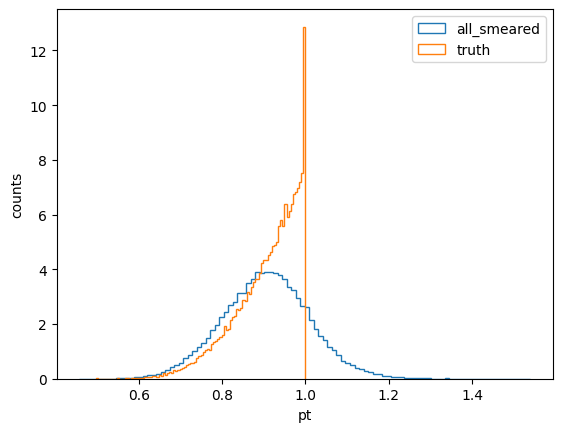

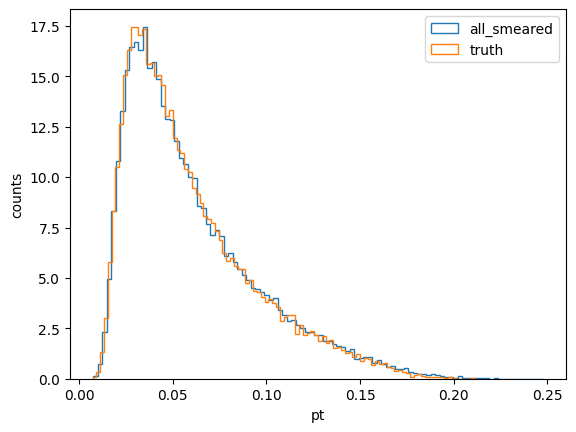

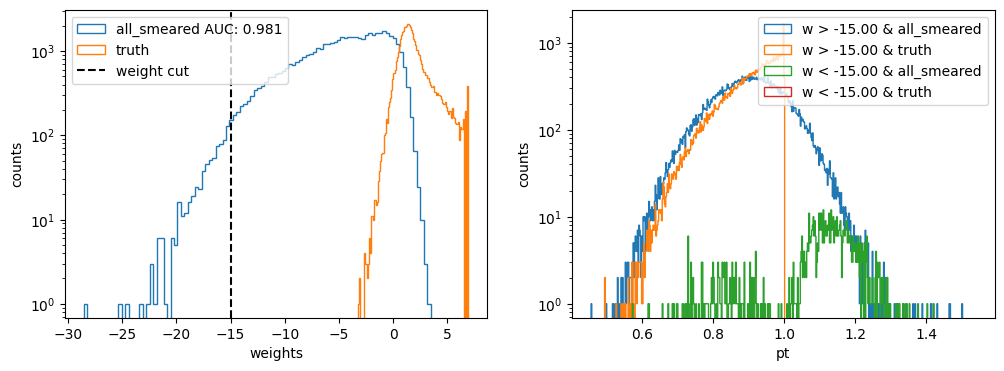

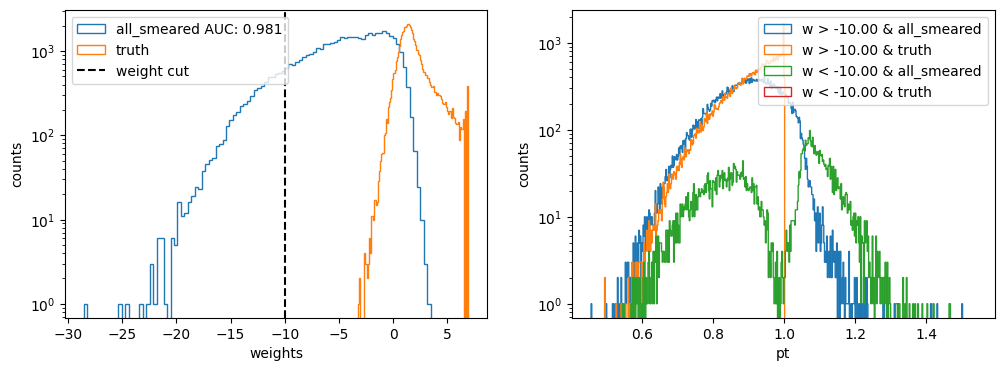

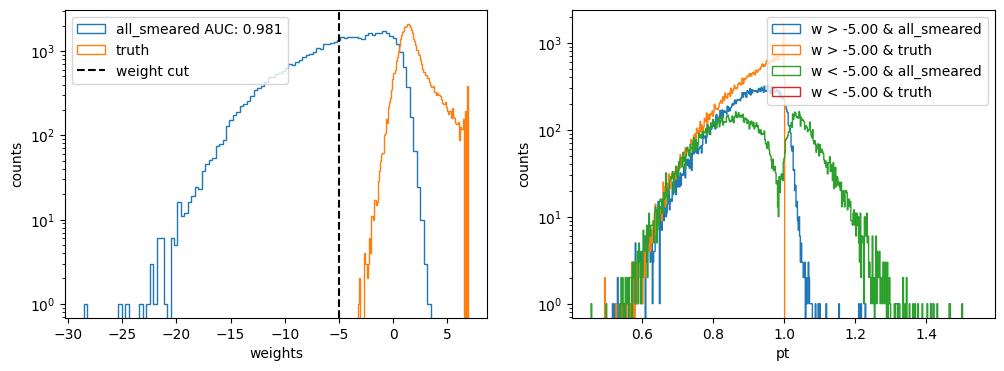

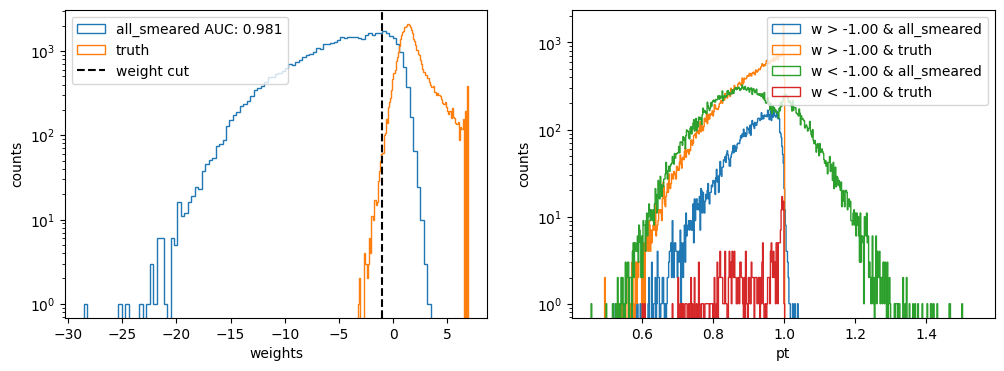

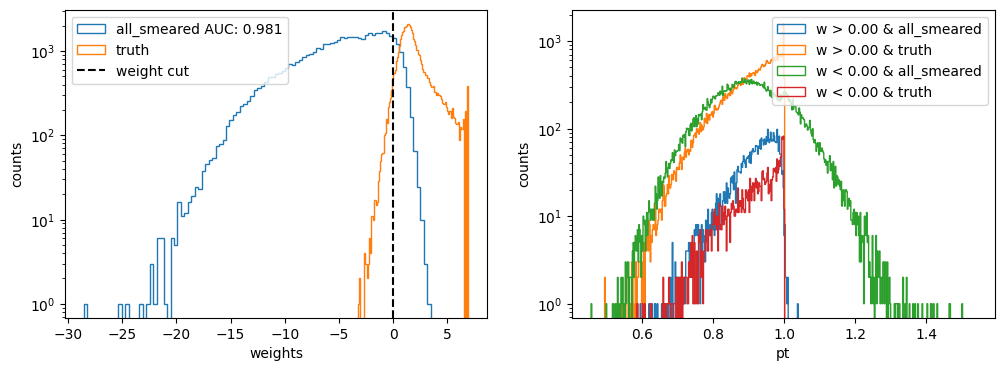

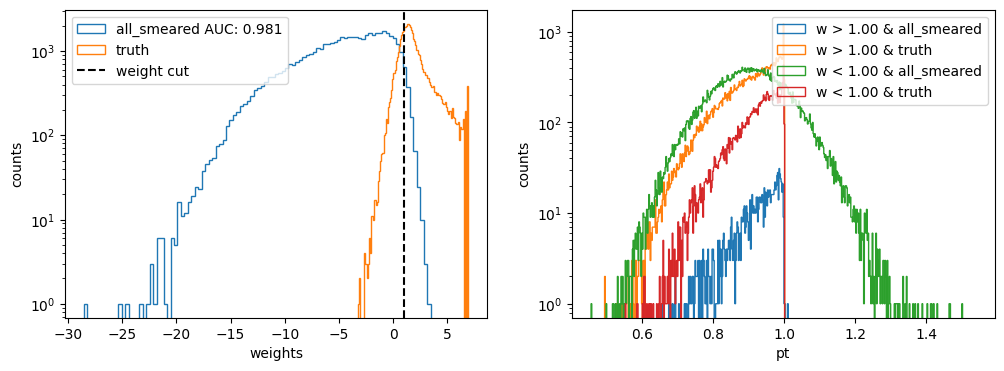

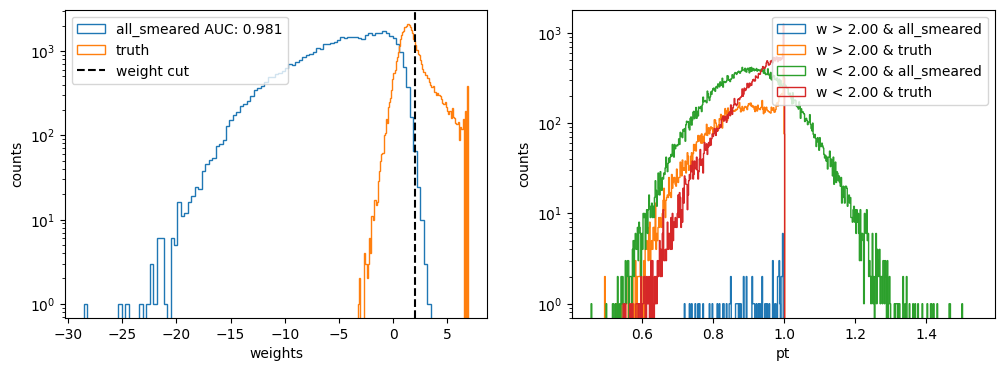

In [13]:
key = 'all_smeared'
data = data_dict[key]
auc = roc_auc_score(data['label'], data['score'])
weight_ = data['score']/(1-data['score'])

label = data['label'][(weight_!=np.inf) & (weight_!=0.)]
jets = data['jets']

pt_ = pt_jets(jets)

pt_ = pt_[(weight_!=np.inf) & (weight_!=0.)]



weight_ = weight_[(weight_!=np.inf) & (weight_!=0.)]


weight = np.log10(weight_ + 10**(-80))


 
# plot pt distribution
plt.hist(pt_[label==0],bins = 100, label = key,histtype='step',density=True)
plt.hist(pt_[label==1],bins = 100, label = 'truth', histtype='step',density=True)
plt.legend(loc = 'upper right')
plt.xlabel('pt')
plt.ylabel('counts')
plt.show()

plt.hist(data['mass'][data['label']==0],bins = 100, label = key,histtype='step',density=True)
plt.hist(data['mass'][data['label']==1],bins = 100, label = 'truth', histtype='step',density=True)
plt.legend(loc = 'upper right')
plt.xlabel('pt')
plt.ylabel('counts')
plt.show()

for cut in [-15,-10,-5,-1,0, 1, 2]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# plot 1
    bins = np.arange(min(pt_), max(pt_), 0.002)
    ax1.hist(weight[label==0],bins = 100, label = f'{key} AUC: {auc:.3f}',histtype='step',
             density=False)
    ax1.hist(weight[label==1],bins = 100, label = 'truth', histtype='step',
             density=False)
    # plot verticle line at 1
    ax1.axvline(x=cut, color='k', linestyle='--', label = 'weight cut')

    ax1.legend(loc = 'upper left')
    ax1.set_xlabel('weights')
    ax1.set_ylabel('counts')
    ax1.set_yscale('log')
   # ax1.set_xscale('log')
    ax1.legend(loc = 'upper left')

    ax2.hist(pt_[(weight>cut) & (label==0)],bins = bins, label = f'w > {cut:.2f} & {key}',histtype='step'
             ,density=False)
    ax2.hist(pt_[(weight>cut) & (label==1)],bins = bins, label = f'w > {cut:.2f} & truth', histtype='step',
             density=False)
    ax2.hist(pt_[(weight<cut) & (label==0)],bins = bins, label = f'w < {cut:.2f} & {key}',histtype='step'
             ,density=False)
    ax2.hist(pt_[(weight<cut) & (label==1)],bins = bins, label = f'w < {cut:.2f} & truth', histtype='step',
             density=False)
    ax2.legend(loc = 'upper right')

    plt.xlabel('pt')
    plt.ylabel('counts')
    plt.yscale('log')
    plt.show()






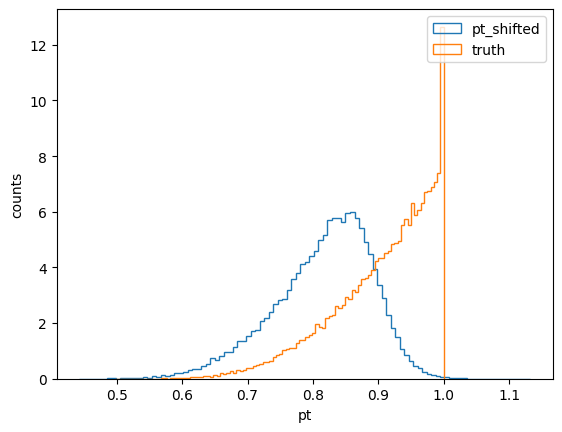

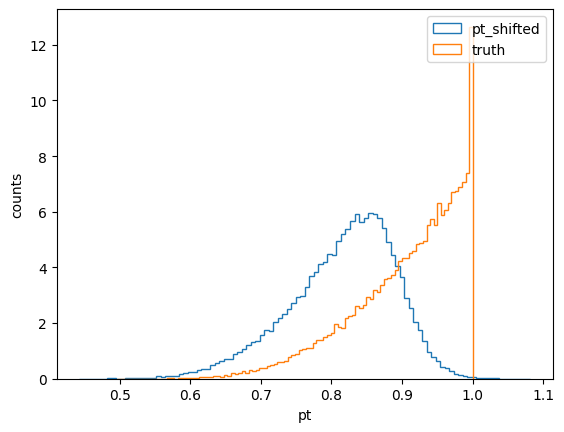

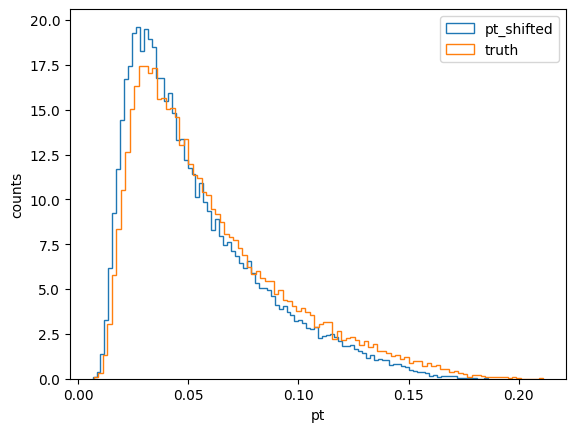

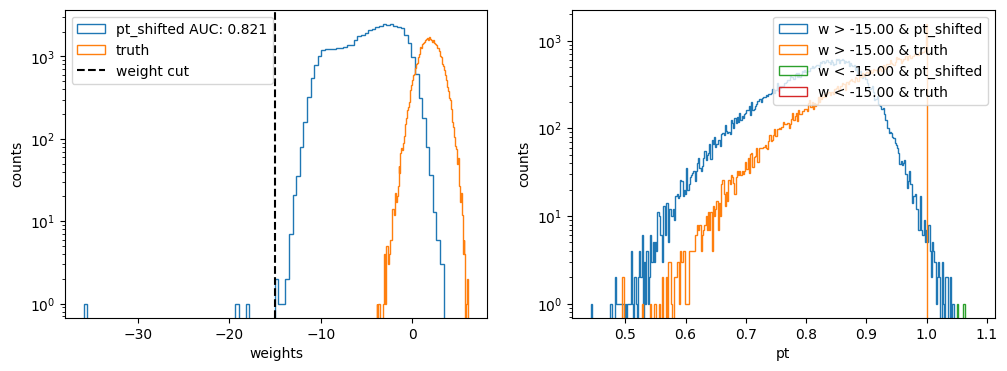

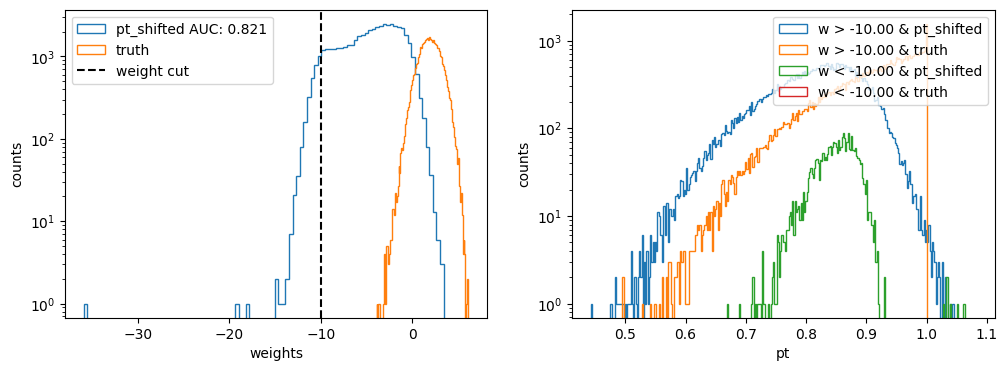

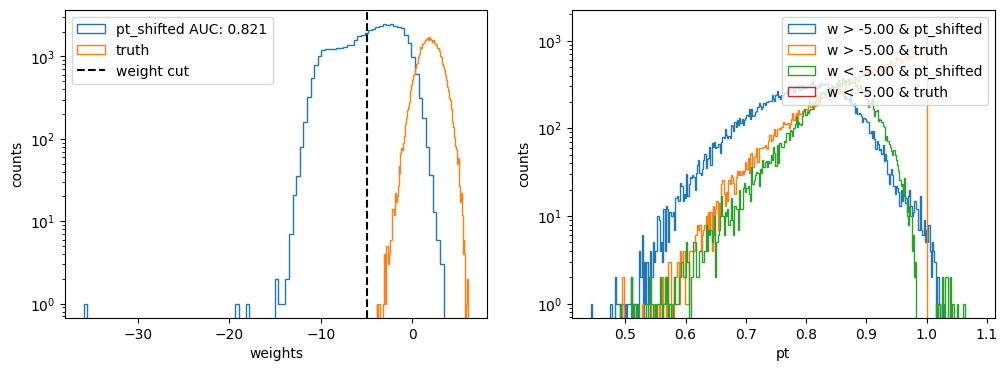

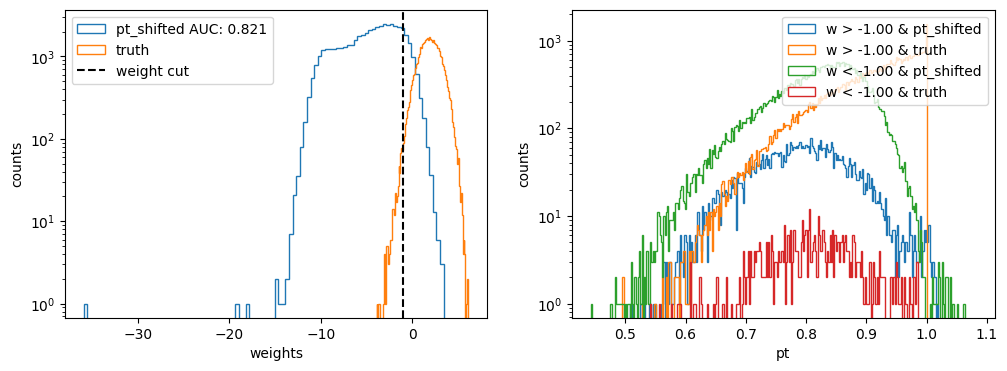

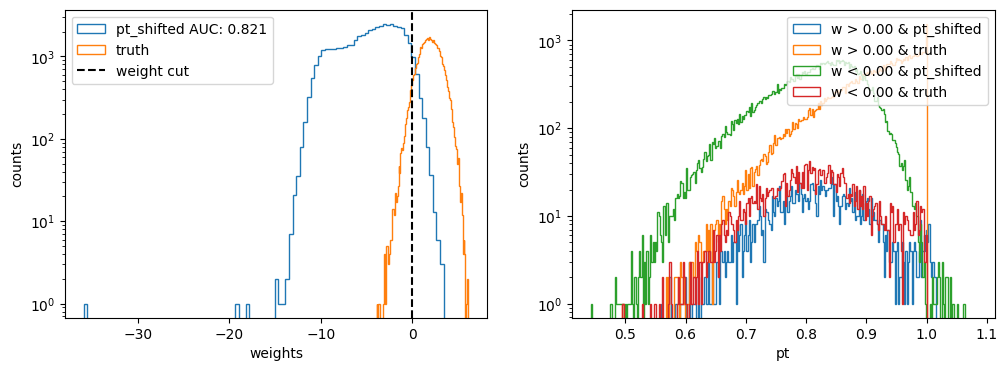

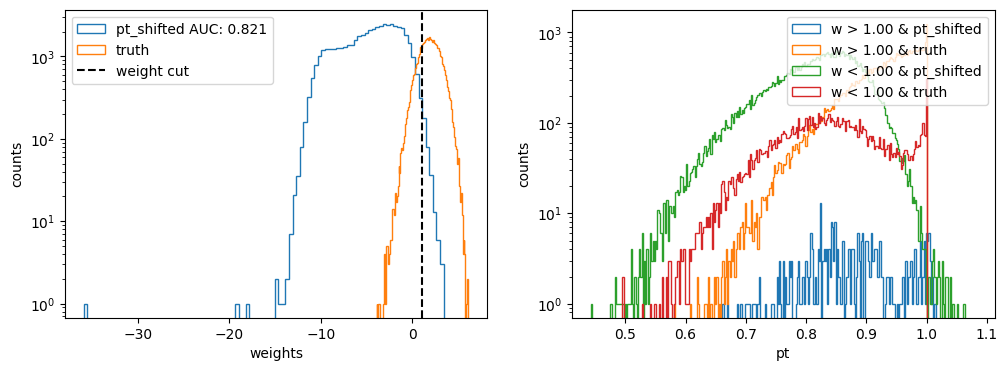

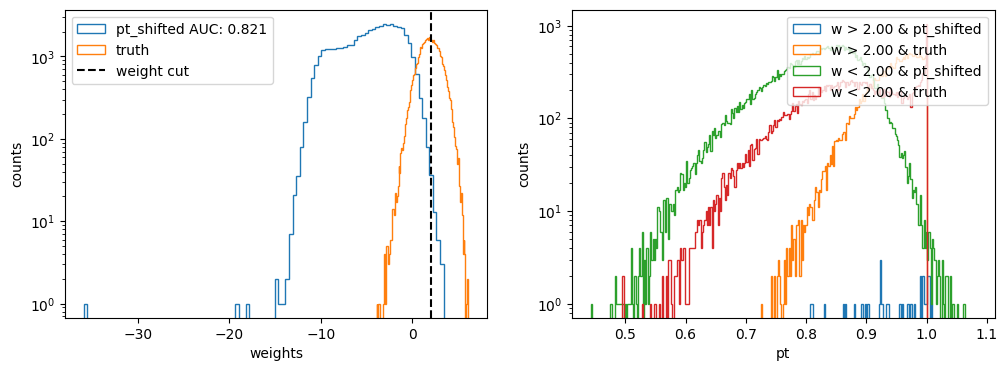

In [18]:
key = 'pt_shifted'
data = data_dict[key]

jets = data['jets']

pt_ = pt_jets(jets)
 
# plot pt distribution
plt.hist(pt_[data['label']==0],bins = 100, label = key,histtype='step',density=True)
plt.hist(pt_[data['label']==1],bins = 100, label = 'truth', histtype='step',density=True)
plt.legend(loc = 'upper right')
plt.xlabel('pt')
plt.ylabel('counts')
plt.show()


weight_ = data['score']/(1-data['score'])

label = data['label'][(weight_!=np.inf) & (weight_!=0.)]
jets = data['jets']

pt_ = pt_jets(jets)

pt_ = pt_[(weight_!=np.inf) & (weight_!=0.)]



weight_ = weight_[(weight_!=np.inf) & (weight_!=0.)]


weight = np.log10(weight_ + 10**(-80))


 
# plot pt distribution
plt.hist(pt_[label==0],bins = 100, label = key,histtype='step',density=True)
plt.hist(pt_[label==1],bins = 100, label = 'truth', histtype='step',density=True)
plt.legend(loc = 'upper right')
plt.xlabel('pt')
plt.ylabel('counts')
plt.show()

plt.hist(data['mass'][data['label']==0],bins = 100, label = key,histtype='step',density=True)
plt.hist(data['mass'][data['label']==1],bins = 100, label = 'truth', histtype='step',density=True)
plt.legend(loc = 'upper right')
plt.xlabel('pt')
plt.ylabel('counts')
plt.show()

for cut in [-15,-10,-5,-1,0, 1, 2]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# plot 1
    bins = np.arange(min(pt_), max(pt_), 0.002)
    ax1.hist(weight[label==0],bins = 100, label = f'{key} AUC: {auc:.3f}',histtype='step',
             density=False)
    ax1.hist(weight[label==1],bins = 100, label = 'truth', histtype='step',
             density=False)
    # plot verticle line at 1
    ax1.axvline(x=cut, color='k', linestyle='--', label = 'weight cut')

    ax1.legend(loc = 'upper left')
    ax1.set_xlabel('weights')
    ax1.set_ylabel('counts')
    ax1.set_yscale('log')
   # ax1.set_xscale('log')
    ax1.legend(loc = 'upper left')

    ax2.hist(pt_[(weight>cut) & (label==0)],bins = bins, label = f'w > {cut:.2f} & {key}',histtype='step'
             ,density=False)
    ax2.hist(pt_[(weight>cut) & (label==1)],bins = bins, label = f'w > {cut:.2f} & truth', histtype='step',
             density=False)
    ax2.hist(pt_[(weight<cut) & (label==0)],bins = bins, label = f'w < {cut:.2f} & {key}',histtype='step'
             ,density=False)
    ax2.hist(pt_[(weight<cut) & (label==1)],bins = bins, label = f'w < {cut:.2f} & truth', histtype='step',
             density=False)
    ax2.legend(loc = 'upper right')

    plt.xlabel('pt')
    plt.ylabel('counts')
    plt.yscale('log')
    plt.show()



In [54]:
labels = np.array([data['label'].tolist() for i in range(30)]).reshape(-1,30)
print(labels.shape)


(100000, 30)


/home/rd804/discriminator-metric/scripts/conversion.py:128: RuntimeWarning: invalid value encountered in divide
  eta = 0.5*np.log((En+pz)/(En-pz))


(3000000,) (3000000,) (3000000,)


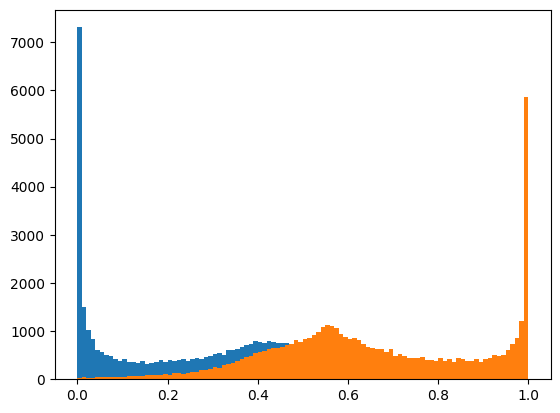

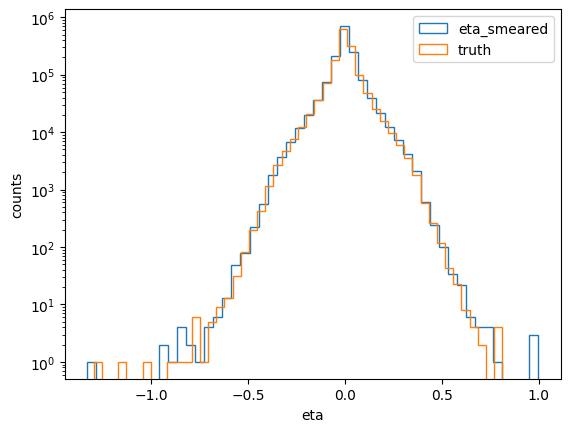

/tmp/ipykernel_2625513/1216426269.py:40: RuntimeWarning: divide by zero encountered in divide
  weight_ = score/(1-score)


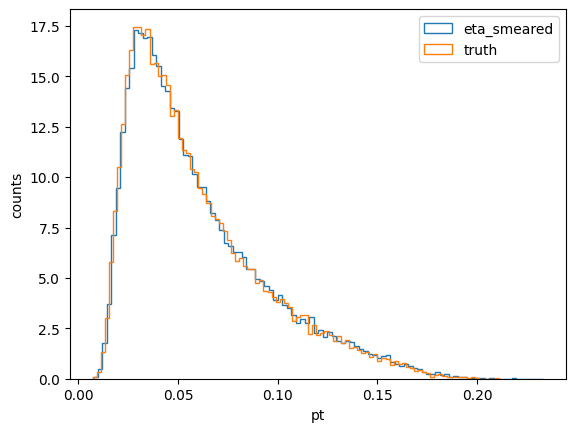

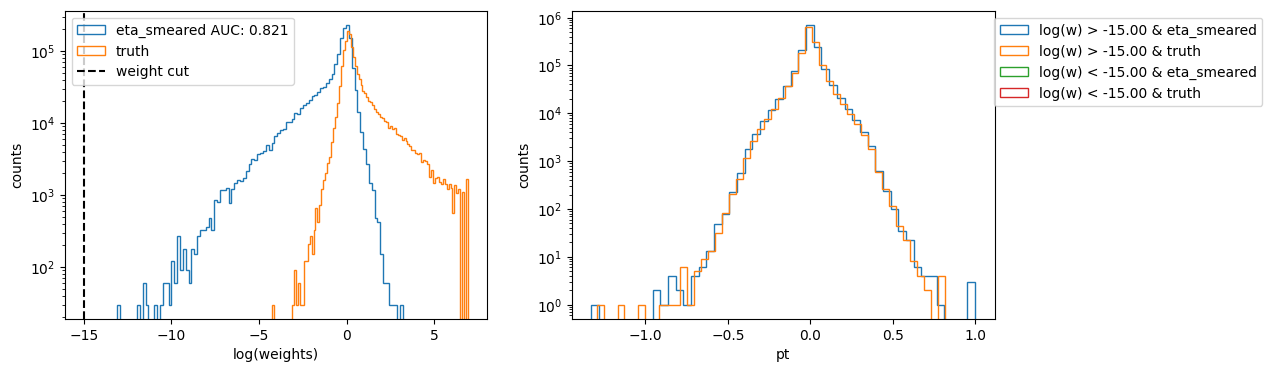

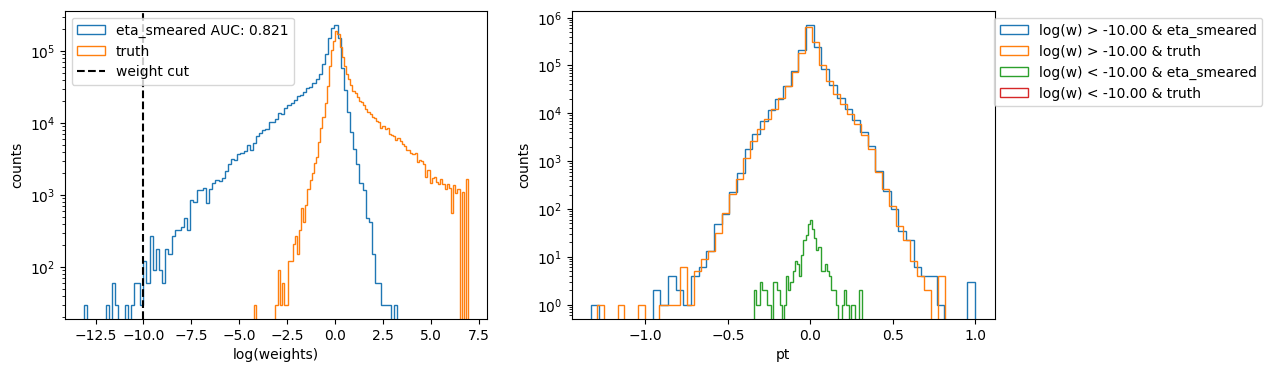

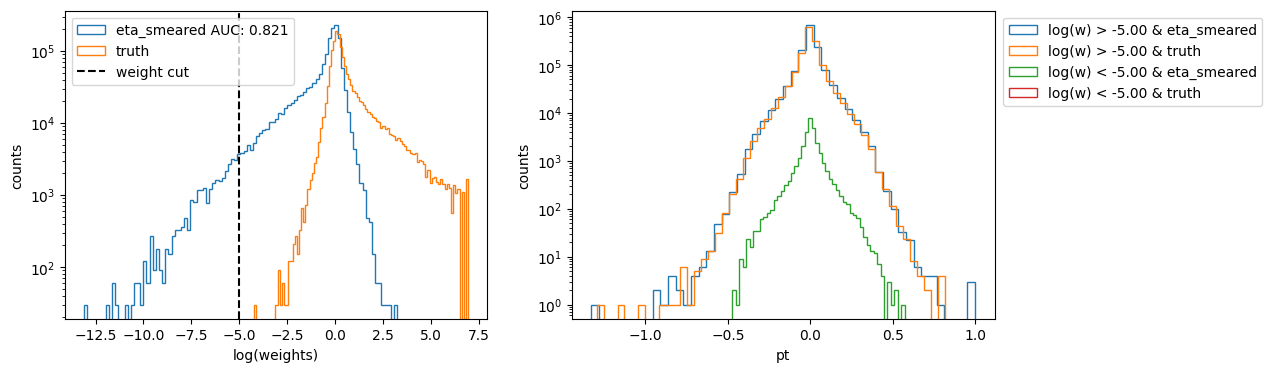

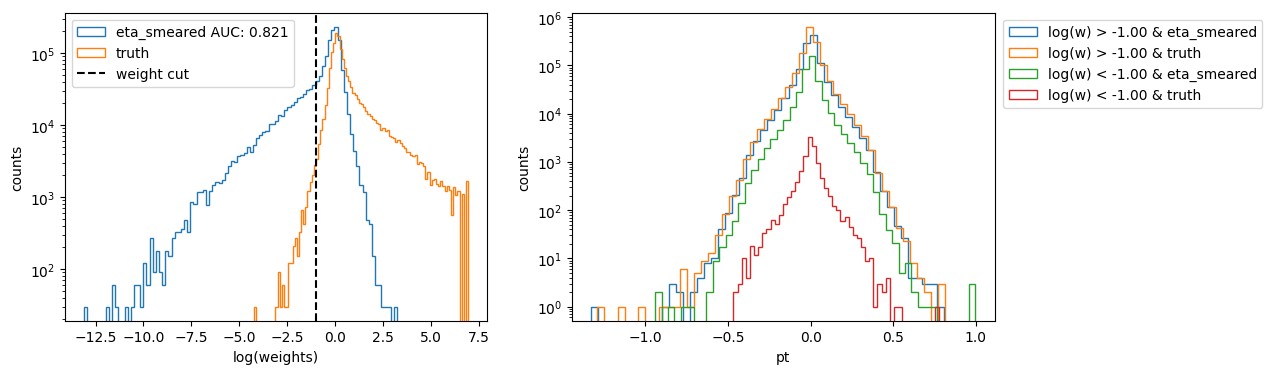

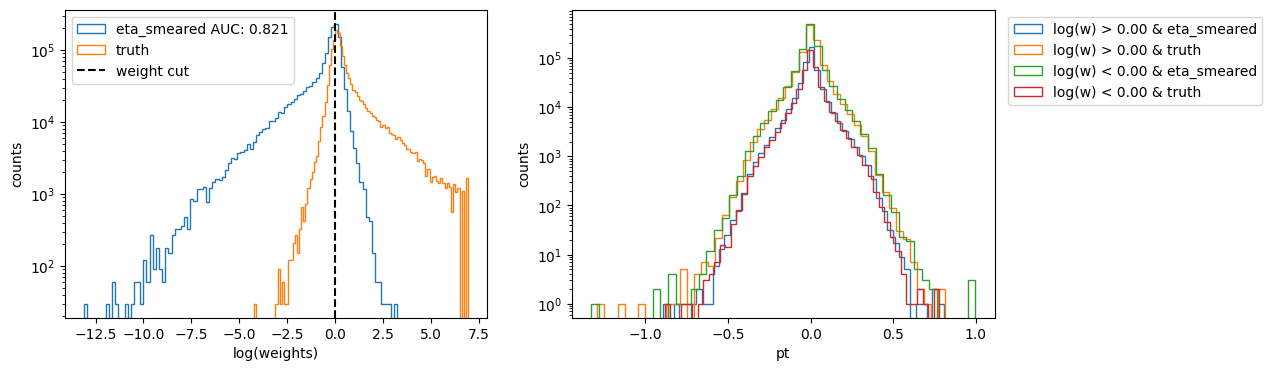

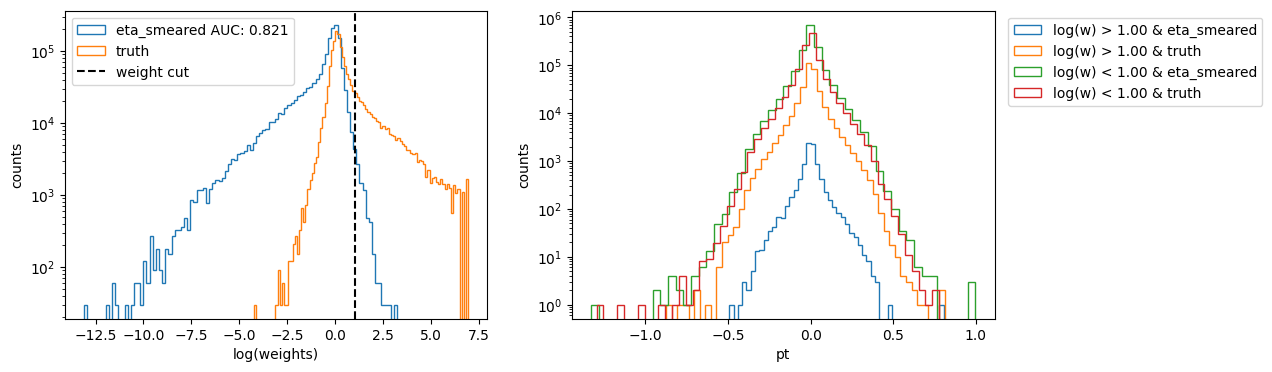

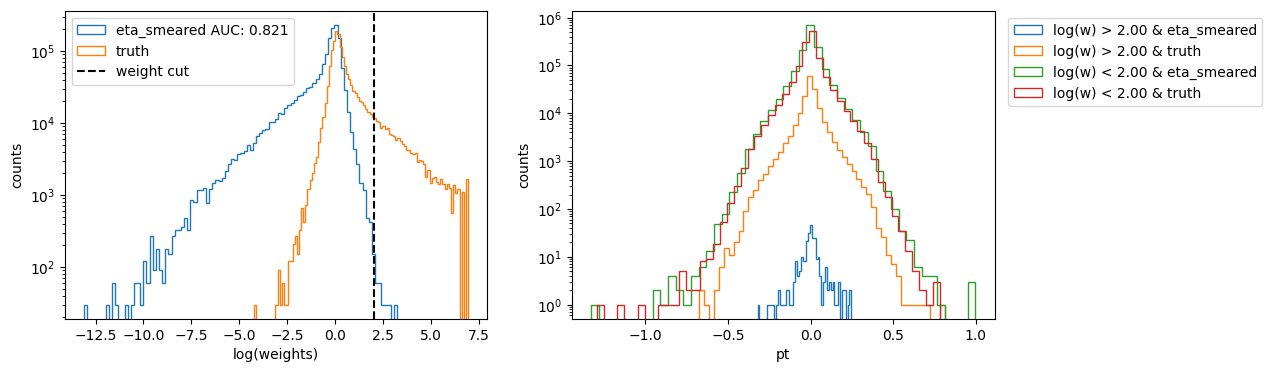

In [56]:
key = 'eta_smeared'
data = data_dict[key]


auc = roc_auc_score(data['label'], data['score'])
jets = data['jets']

# convert jets to polar
polar_jets = cart_to_ptetaphiE(jets)

eta_jet = polar_jets[...,1].flatten()

labels = np.array([data['label'].tolist() for i in range(30)]).reshape(-1,30).flatten()
score = np.array([data['score'].tolist() for i in range(30)]).reshape(-1,30).flatten()

print(eta_jet.shape, score.shape, labels.shape)

#eta_jet = eta_jets(jets)
bins = 50
#bins = np.arange(min(eta_jet), max(eta_jet), 0.005)

#plot score
plt.hist(data['score'][data['label']==0],bins=100)
plt.hist(data['score'][data['label']==1],bins=100)
plt.show()



plt.hist(eta_jet[labels==0], bins=bins,  label = key, histtype='step')
plt.hist(eta_jet[labels==1], bins=bins, label = 'truth', histtype='step')
plt.legend(loc = 'upper right')
plt.yscale('log')
plt.xlabel('eta')
plt.ylabel('counts')
plt.show()




weight_ = score/(1-score)

label = labels[(weight_!=np.inf) & (weight_!=0.)]
#label = data['label'][(weight_!=np.inf) & (weight_!=0.)]
jets = data['jets']


pt_ = eta_jet[(weight_!=np.inf) & (weight_!=0.)]



weight_ = weight_[(weight_!=np.inf) & (weight_!=0.)]


weight = np.log10(weight_ + 10**(-80))


plt.hist(data['mass'][data['label']==0],bins = 100, label = key,histtype='step',density=True)
plt.hist(data['mass'][data['label']==1],bins = 100, label = 'truth', histtype='step',density=True)
plt.legend(loc = 'upper right')
plt.xlabel('pt')
plt.ylabel('counts')
plt.show()

for cut in [-15,-10,-5,-1,0, 1, 2]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# plot 1
    ax1.hist(weight[label==0],bins = 100, label = f'{key} AUC: {auc:.3f}',histtype='step',
             density=False)
    ax1.hist(weight[label==1],bins = 100, label = 'truth', histtype='step',
             density=False)
    # plot verticle line at 1
    ax1.axvline(x=cut, color='k', linestyle='--', label = 'weight cut')

    ax1.legend(loc = 'upper left')
    ax1.set_xlabel('log(weights)')
    ax1.set_ylabel('counts')
    ax1.set_yscale('log')
   # ax1.set_xscale('log')
    ax1.legend(loc = 'upper left')

    ax2.hist(pt_[(weight>cut) & (label==0)],bins = bins, label = f'log(w) > {cut:.2f} & {key}',histtype='step'
             ,density=False)
    ax2.hist(pt_[(weight>cut) & (label==1)],bins = bins, label = f'log(w) > {cut:.2f} & truth', histtype='step',
             density=False)
    ax2.hist(pt_[(weight<cut) & (label==0)],bins = bins, label = f'log(w) < {cut:.2f} & {key}',histtype='step'
             ,density=False)
    ax2.hist(pt_[(weight<cut) & (label==1)],bins = bins, label = f'log(w) < {cut:.2f} & truth', histtype='step',
             density=False)
    ax2.legend(bbox_to_anchor=(1.65,1),loc = 'upper right')

    plt.xlabel('pt')
    plt.ylabel('counts')
    plt.yscale('log')
    plt.show()






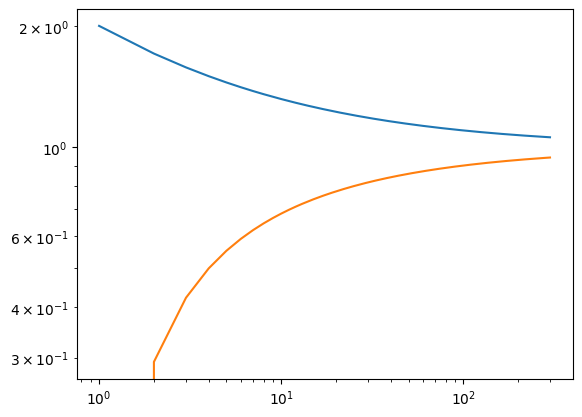

In [16]:
x = np.arange(1,300,1)

plt.plot(x,(x+np.sqrt(x))/x)
plt.plot(x,(x-np.sqrt(x))/x)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [39]:
normal = np.random.normal(0.9, 0.1,size=polar_jets[...,1].shape)

In [62]:
normal[:,0]-normal[:,1]

array([-0.03357328,  0.11038902, -0.17612949, ...,  0.09534714,
        0.10204749, -0.11086036])

In [38]:
polar_jets.shape

(100000, 30, 4)

In [40]:
distortion = polar_jets[...,1]*normal

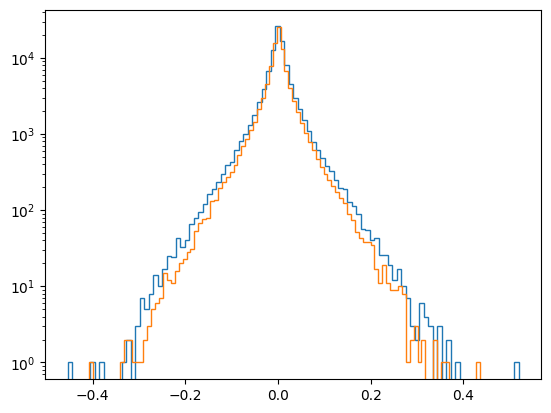

In [44]:
plt.hist(polar_jets[...,1][:,0],bins=100,histtype='step')
plt.hist(distortion[:,0],bins=100,histtype='step')
plt.yscale('log')
plt.show()